In [5]:
import pandas as pd
import os

# --- Configuration ---
file_name = "250331 Leng Survey. Full download. Editable.xlsx"
file_path = file_name # Or provide the full path

# --- Reading all sheets ---
try:
    all_sheets_dict = pd.read_excel(file_path, sheet_name=None)
    print("Successfully read all sheets.")
    print(f"Sheet names found: {list(all_sheets_dict.keys())}")

    # --- Accessing the DataFrames ---
    # You now have DataFrames for each sheet in the dictionary:

    df_all_responses = all_sheets_dict['All responses']
    df_pa_survey = all_sheets_dict['PA Survey']
    df_aa_survey = all_sheets_dict['AA Survey']

    # --- Example: Print shapes or heads ---
    print("\n--- DataFrame Details ---")
    print(f"Shape of 'All responses': {df_all_responses.shape}")
    # print("Head of 'All responses':\n", df_all_responses.head()) # Uncomment to view

    print(f"\nShape of 'PA Survey': {df_pa_survey.shape}")
    # print("Head of 'PA Survey':\n", df_pa_survey.head()) # Uncomment to view

    print(f"\nShape of 'AA Survey': {df_aa_survey.shape}")
    # print("Head of 'AA Survey':\n", df_aa_survey.head()) # Uncomment to view

    # Or iterate through them:
    print("\n--- Iterating ---")
    for sheet_name, df in all_sheets_dict.items():
        print(f"Processing sheet: '{sheet_name}' with shape {df.shape}")
        # Add your analysis for each df here

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully read all sheets.
Sheet names found: ['All responses', 'PA Survey', 'AA Survey']

--- DataFrame Details ---
Shape of 'All responses': (8558, 138)

Shape of 'PA Survey': (6864, 137)

Shape of 'AA Survey': (1694, 137)

--- Iterating ---
Processing sheet: 'All responses' with shape (8558, 138)
Processing sheet: 'PA Survey' with shape (6864, 137)
Processing sheet: 'AA Survey' with shape (1694, 137)


In [6]:
import pandas as pd
import numpy as np

# --- ASSUMPTION ---
# This code assumes the 'all_sheets_dict' dictionary containing your DataFrames
# already exists in your environment from the previous steps.
# It specifically expects the 'All responses' sheet to be present.
# If not, you would first need to run the code that does:
# file_path = "250331 Leng Survey. Full download. Editable.xlsx"
# all_sheets_dict = pd.read_excel(file_path, sheet_name=None)
# --- END ASSUMPTION ---

sheet_name = 'All responses'
print(f"--- Analyzing columns of sheet: '{sheet_name}' ---")

try:
    # --- Get the target DataFrame ---
    if 'all_sheets_dict' not in locals():
        raise NameError("The dictionary 'all_sheets_dict' does not exist. Please run the reading code first.")
    if sheet_name not in all_sheets_dict:
        raise KeyError(f"Sheet name '{sheet_name}' not found in the dictionary. Available sheets: {list(all_sheets_dict.keys())}")

    # Assign the specific DataFrame to the variable name you mentioned
    df_all_responses = all_sheets_dict[sheet_name]

    # --- Create Metadata DataFrame (describing columns of df_all_responses) ---
    print("Calculating unique values for each column in df_all_responses...")
    column_unique_counts = df_all_responses.nunique()

    # Create a DataFrame to hold metadata about the columns
    # The index of this DataFrame will be the column names from df_all_responses
    column_metadata_df = pd.DataFrame({
        'UniqueValues': column_unique_counts,
        'DataType': df_all_responses.dtypes # Added data type back for context
    })

    # --- Add the ResponseType classification to the metadata DataFrame ---
    print("Classifying columns based on unique value count...")
    column_metadata_df['ResponseType'] = np.where(
        column_metadata_df['UniqueValues'] <= 10, # Condition
        'Fixed Response',                         # Value if True
        'Open Text'                               # Value if False
    )

    # --- Display the Column Metadata ---
    print("\n--- Column Metadata DataFrame ---")
    print("(Describes the columns in 'df_all_responses')")
    with pd.option_context('display.max_rows', None):
        print(column_metadata_df)

    # --- How to USE this metadata with df_all_responses ---
    print("\n--- Example Usage ---")

    # 1. Get a list of column names classified as 'Open Text'
    open_text_column_names = column_metadata_df[column_metadata_df['ResponseType'] == 'Open Text'].index.tolist()
    print(f"\nNumber of 'Open Text' columns found: {len(open_text_column_names)}")
    if open_text_column_names:
        print(f"First few 'Open Text' columns: {open_text_column_names[:5]}...") # Show first 5

    # 2. Get a list of column names classified as 'Fixed Response'
    fixed_response_column_names = column_metadata_df[column_metadata_df['ResponseType'] == 'Fixed Response'].index.tolist()
    print(f"\nNumber of 'Fixed Response' columns found: {len(fixed_response_column_names)}")
    if fixed_response_column_names:
        print(f"First few 'Fixed Response' columns: {fixed_response_column_names[:5]}...") # Show first 5

    # 3. Create a new DataFrame containing only the 'Open Text' columns from the original data
    if open_text_column_names:
        df_open_text_only = df_all_responses[open_text_column_names]
        print("\nCreated 'df_open_text_only' DataFrame with shape:", df_open_text_only.shape)
        # print(df_open_text_only.head()) # Uncomment to see the head

    # 4. Create a new DataFrame containing only the 'Fixed Response' columns
    if fixed_response_column_names:
        df_fixed_response_only = df_all_responses[fixed_response_column_names]
        print("Created 'df_fixed_response_only' DataFrame with shape:", df_fixed_response_only.shape)
        # print(df_fixed_response_only.head()) # Uncomment to see the head


except (NameError, KeyError) as e:
     print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print(f"\n--- Column analysis and classification complete for '{sheet_name}' ---")

--- Analyzing columns of sheet: 'All responses' ---
Calculating unique values for each column in df_all_responses...
Classifying columns based on unique value count...

--- Column Metadata DataFrame ---
(Describes the columns in 'df_all_responses')
                                                    UniqueValues  \
Which survey would you like to complete?                       2   
Do you work (currently or previously) as one of...           384   
Unnamed: 2                                                     0   
Do you work (currently or previously) as one of...            74   
Which organisation do you work for?                          691   
In which healthcare setting do you work?                      28   
In which healthcare setting do you work?.1                    12   
In which region is the service where you most r...            20   
When did you last work in a healthcare setting ...             4   
In which organisation did you most recently wor...          2512   
In 

# Detecting suspicious responses

## 1. Completion time analysis
*Respondents answering unreasonably fast are suspicious (bots or not reading)*

In [7]:
import pandas as pd
import numpy as np

# --- ASSUMPTION ---
# This code assumes the 'df_all_responses' DataFrame already exists
# in your environment from the previous steps.
# If not, you would first need to run the code that loads it, e.g.:
# file_path = "250331 Leng Survey. Full download. Editable.xlsx"
# all_sheets_dict = pd.read_excel(file_path, sheet_name=None)
# df_all_responses = all_sheets_dict['All responses']
# --- END ASSUMPTION ---

print("\n--- Running Idea 1: Completion Time Analysis ---")

# Define the columns needed
start_col = 'Started'
end_col = 'Completed'

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
         raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if not all(col in df_all_responses.columns for col in [start_col, end_col]):
        missing = [col for col in [start_col, end_col] if col not in df_all_responses.columns]
        raise KeyError(f"Required columns missing from df_all_responses: {missing}")

    # --- 1. Convert to Datetime ---
    # Create new columns to avoid modifying originals immediately if preferred
    # errors='coerce' will turn unparseable dates into NaT (Not a Time)
    df_all_responses[f'{start_col}_dt'] = pd.to_datetime(df_all_responses[start_col], errors='coerce')
    df_all_responses[f'{end_col}_dt'] = pd.to_datetime(df_all_responses[end_col], errors='coerce')

    # --- 2. Calculate Duration ---
    df_all_responses['Duration'] = df_all_responses[f'{end_col}_dt'] - df_all_responses[f'{start_col}_dt']
    df_all_responses['Duration_sec'] = df_all_responses['Duration'].dt.total_seconds()

    # --- 3. Report on Missing Durations ---
    initial_rows = len(df_all_responses)
    valid_duration_count = df_all_responses['Duration_sec'].notna().sum()
    if initial_rows != valid_duration_count:
        print(f"\nWarning: Could not calculate duration for {initial_rows - valid_duration_count} out of {initial_rows} rows.")
        print("         This is likely due to missing or invalid data in 'Started' or 'Completed' columns.")

    # --- 4. Show Duration Statistics ---
    print("\n--- Distribution of Completion Times (in seconds) ---")
    if valid_duration_count > 0:
        # Use dropna() to calculate stats only on valid durations
        duration_stats = df_all_responses['Duration_sec'].dropna().describe(
            percentiles=[.01, .05, .10, .25, .5, .75, .90, .95, .99] # Include useful percentiles
        )
        # Make sure output format handles potentially large numbers
        with pd.option_context('display.float_format', '{:,.2f}'.format):
            print(duration_stats)
    else:
        print("No valid durations found to calculate statistics.")

    # --- 5. Define and Apply Threshold ---
    # Using 5th percentile as an example threshold for "too fast"
    percentile_to_flag = 0.05
    time_threshold_sec = None # Initialize

    if valid_duration_count > 0:
        time_threshold_sec = df_all_responses['Duration_sec'].dropna().quantile(percentile_to_flag)

    print(f"\n--- Flagging Responses Below {percentile_to_flag*100:.0f}th Percentile ---")
    if pd.notna(time_threshold_sec):
         print(f"Calculated Threshold: {time_threshold_sec:.2f} seconds")
         # Apply flag: True if Duration_sec is less than threshold
         df_all_responses['Flag_ShortTime'] = df_all_responses['Duration_sec'] < time_threshold_sec
         # Important: Ensure rows where duration couldn't be calculated (NaN) are NOT flagged
         df_all_responses['Flag_ShortTime'] = df_all_responses['Flag_ShortTime'].fillna(False)
    else:
         print("Could not calculate a valid threshold (perhaps too few valid durations). Setting all flags to False.")
         df_all_responses['Flag_ShortTime'] = False # Assign False to all rows

    # --- 6. Show Results ---
    flagged_count = df_all_responses['Flag_ShortTime'].sum()
    print(f"\n--- Results of Short Time Check ---")
    print(f"Total responses analyzed: {initial_rows}")
    print(f"Number of responses flagged as potentially too short (< {time_threshold_sec:.2f} sec): {flagged_count}")
    if initial_rows > 0:
        print(f"Percentage flagged: {flagged_count / initial_rows * 100:.2f}%")

    if flagged_count > 0:
        print("\n--- Sample of Flagged Responses (Sorted by Duration) ---")
        # Select relevant columns to display context
        cols_to_show = [
            'Duration_sec',
            'Flag_ShortTime',
            start_col, # Original timestamp cols
            end_col,
            # Add other potentially useful columns if they exist
            'Response ID',
            'Status',
            'Test response'
         ]
        # Filter out columns that might not exist in the specific df
        cols_to_show = [col for col in cols_to_show if col in df_all_responses.columns]

        # Show the top N fastest flagged responses
        with pd.option_context('display.max_rows', 20, 'display.max_columns', None, 'display.width', 1000):
             print(df_all_responses[df_all_responses['Flag_ShortTime']][cols_to_show].sort_values('Duration_sec').head(15)) # Show up to 15 fastest

except NameError as e:
     print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print(f"\n--- Completion Time Analysis Finished ---")
print(f"The DataFrame 'df_all_responses' now has a 'Flag_ShortTime' column.")


--- Running Idea 1: Completion Time Analysis ---

--- Distribution of Completion Times (in seconds) ---
count       8,558.00
mean       13,604.58
std       112,978.50
min           120.00
1%            240.00
5%            300.00
10%           360.00
25%           540.00
50%           900.00
75%         1,680.00
90%         3,540.00
95%         8,049.00
99%       287,357.40
max     1,819,440.00
Name: Duration_sec, dtype: float64

--- Flagging Responses Below 5th Percentile ---
Calculated Threshold: 300.00 seconds

--- Results of Short Time Check ---
Total responses analyzed: 8558
Number of responses flagged as potentially too short (< 300.00 sec): 165
Percentage flagged: 1.93%

--- Sample of Flagged Responses (Sorted by Duration) ---
      Duration_sec  Flag_ShortTime             Started           Completed                           Response ID     Status  Test response
1122         120.0            True 2025-03-28 19:06:00 2025-03-28 19:08:00  8550336f-00e8-41ba-a645-770e10f9518c  co

The shortest length of time to respond was 2 minutes (120 seconds). This is quick considering the length of the survey but not quick enough to credibly suggest the use of a bot. SurveyOptic doesn't derive start and complete time to the second so there is a chance these were quicker but this cannot be confirmed. There are a range of responses that have been rounded to 3 minutes completion time.

The code / output below shows the distribution of response times. We see a median of 15 minutes for response time. 50% of the respondents complete within 15 minutes, 90% of the respondents complete within 1 hour. 


--- Response Time Distribution Analysis ---

=== Basic Response Time Statistics (in seconds) ===
Count: 8,558.00
Mean: 13,604.58
Median: 900.00
Standard Deviation: 112,978.50
Minimum: 120.00
Maximum: 1,819,440.00
IQR (Interquartile Range): 1,140.00
5th Percentile: 300.00
25th Percentile: 540.00
75th Percentile: 1,680.00
95th Percentile: 8,049.00


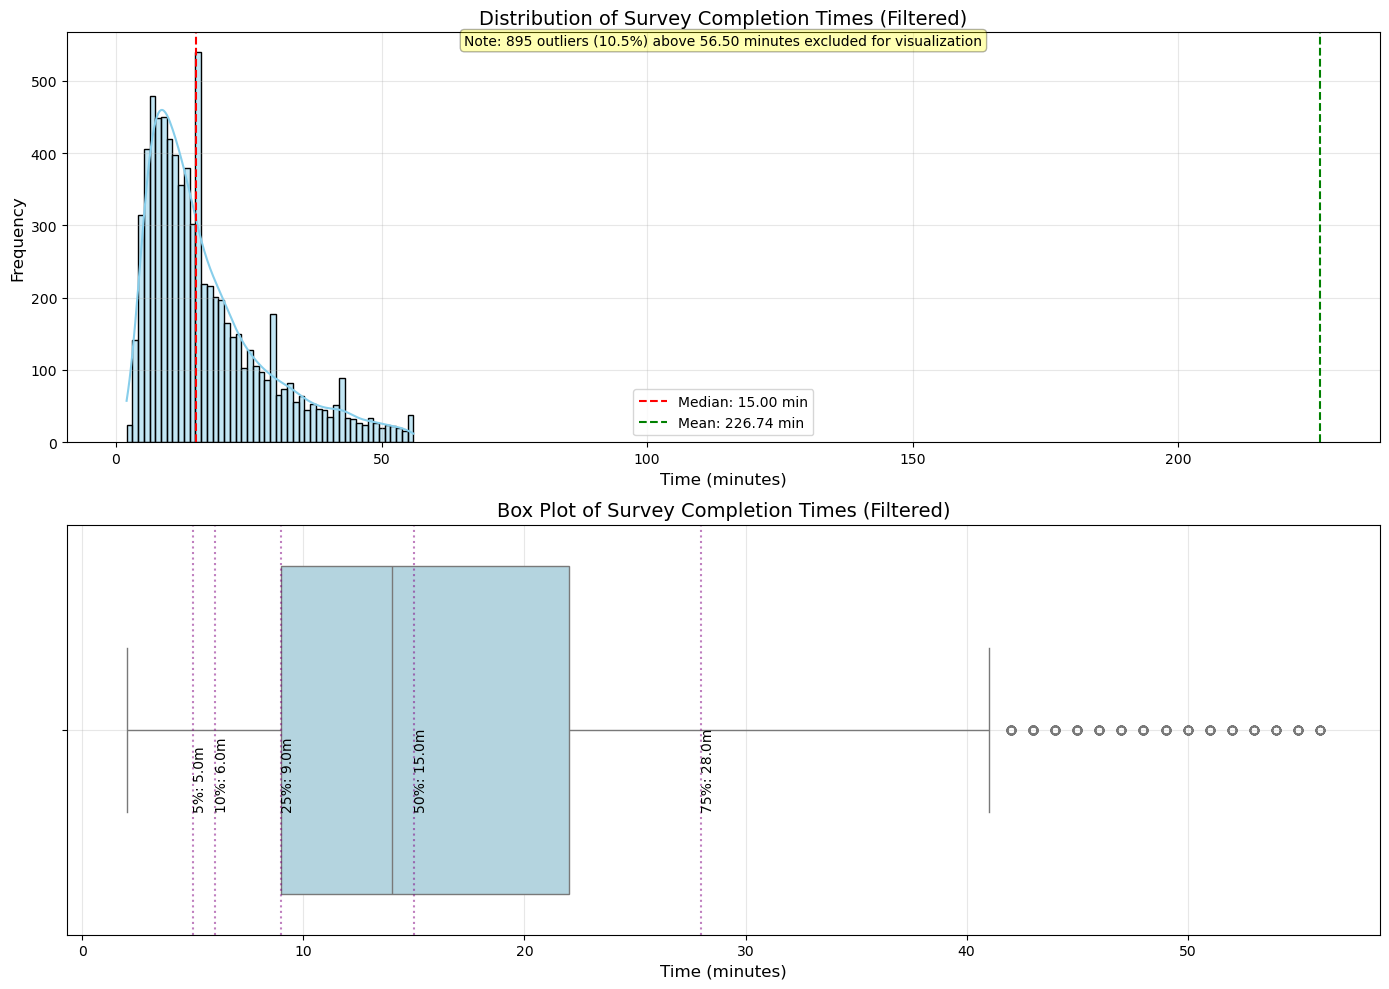


=== Response Time Distribution (in minutes) ===
Time Range           Count      Percentage
----------------------------------------
0-2 minutes          2          0.02      %
2-5 minutes          478        5.59      %
5-10 minutes         2,202      25.73     %
10-15 minutes        1,730      20.22     %
15-30 minutes        2,235      26.12     %
30-60 minutes        1,080      12.62     %
Over 60 minutes      831        9.71      %

=== Additional Insights ===
50% of respondents completed the survey in 15.00 minutes or less
90% of respondents completed the survey in 59.00 minutes or less
Skewness: 12.15 (Positive value indicates right-skewed distribution)
Kurtosis: 158.98 (Positive value indicates heavier tails than a normal distribution)


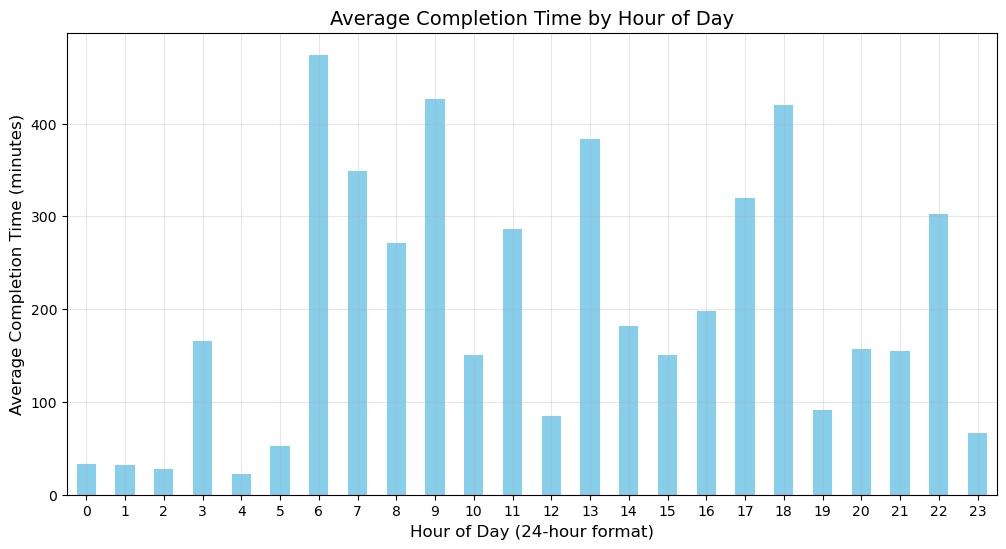


=== Time of Day Analysis ===
Fastest completion times: Hour 4 (Average: 21.98 minutes)
Slowest completion times: Hour 6 (Average: 474.13 minutes)

--- Response Time Distribution Analysis Complete ---


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- ASSUMPTION ---
# This code assumes the 'df_all_responses' DataFrame with 'Duration_sec' column 
# already exists in your environment from the previous steps.
# --- END ASSUMPTION ---

print("\n--- Response Time Distribution Analysis ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if 'Duration_sec' not in df_all_responses.columns:
        raise KeyError("'Duration_sec' column not found in df_all_responses. Please run the completion time analysis first.")
    
    # Create a copy of the duration data, dropping NaN values
    durations = df_all_responses['Duration_sec'].dropna().copy()
    
    # --- 1. Basic Statistics ---
    print("\n=== Basic Response Time Statistics (in seconds) ===")
    stats_to_report = {
        'Count': durations.count(),
        'Mean': durations.mean(),
        'Median': durations.median(),
        'Standard Deviation': durations.std(),
        'Minimum': durations.min(),
        'Maximum': durations.max(),
        'IQR (Interquartile Range)': durations.quantile(0.75) - durations.quantile(0.25),
        '5th Percentile': durations.quantile(0.05),
        '25th Percentile': durations.quantile(0.25),
        '75th Percentile': durations.quantile(0.75),
        '95th Percentile': durations.quantile(0.95)
    }
    
    # Format and display statistics
    for stat_name, stat_value in stats_to_report.items():
        print(f"{stat_name}: {stat_value:,.2f}")
    
    # --- 2. Convert to minutes for better interpretation ---
    durations_min = durations / 60
    
    # --- 3. Identify and handle outliers for visualization ---
    # Using IQR method to identify outliers
    Q1 = durations_min.quantile(0.25)
    Q3 = durations_min.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper bound for visualization (excluding extreme outliers)
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a filtered dataset for better visualization
    durations_for_viz = durations_min[durations_min <= upper_bound]
    outliers_count = len(durations_min) - len(durations_for_viz)
    outliers_percent = (outliers_count / len(durations_min)) * 100
    
    # --- 4. Set up visualization environment ---
    plt.figure(figsize=(14, 10))
    
    # --- 5. Histogram with KDE (Kernel Density Estimate) ---
    plt.subplot(2, 1, 1)
    sns.histplot(durations_for_viz, kde=True, bins=50, color='skyblue')
    plt.axvline(durations_min.median(), color='red', linestyle='--', label=f'Median: {durations_min.median():.2f} min')
    plt.axvline(durations_min.mean(), color='green', linestyle='--', label=f'Mean: {durations_min.mean():.2f} min')
    plt.title('Distribution of Survey Completion Times (Filtered)', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add annotation about filtered outliers
    if outliers_count > 0:
        plt.annotate(f'Note: {outliers_count:,} outliers ({outliers_percent:.1f}%) above {upper_bound:.2f} minutes excluded for visualization',
                     xy=(0.5, 0.97), xycoords='axes fraction', ha='center', fontsize=10, 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    # --- 6. Box Plot ---
    plt.subplot(2, 1, 2)
    sns.boxplot(x=durations_for_viz, color='lightblue')
    plt.title('Box Plot of Survey Completion Times (Filtered)', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add more detailed percentile markers
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    percentile_values = [durations_min.quantile(p/100) for p in percentiles]
    
    for p, v in zip(percentiles, percentile_values):
        if v <= upper_bound:  # Only add if within the visualization range
            plt.axvline(v, color='purple', alpha=0.5, linestyle=':')
            plt.text(v, 0.2, f'{p}%: {v:.1f}m', rotation=90, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.savefig('response_time_distribution.png', dpi=300)
    plt.show()
    
    # --- 7. Calculate time ranges for reporting ---
    print("\n=== Response Time Distribution (in minutes) ===")
    
    # Define time ranges for categorization (in minutes)
    time_ranges = [
        (0, 2),        # 0-2 minutes
        (2, 5),        # 2-5 minutes
        (5, 10),       # 5-10 minutes
        (10, 15),      # 10-15 minutes
        (15, 30),      # 15-30 minutes
        (30, 60),      # 30-60 minutes
        (60, float('inf'))  # Over 60 minutes
    ]
    
    # Count responses in each time range
    range_counts = []
    for start, end in time_ranges:
        if start == 0:
            count = ((durations_min >= start) & (durations_min <= end)).sum()
            label = f"{start}-{end} minutes"
        elif end == float('inf'):
            count = (durations_min > start).sum()
            label = f"Over {start} minutes"
        else:
            count = ((durations_min > start) & (durations_min <= end)).sum()
            label = f"{start}-{end} minutes"
        
        percentage = (count / len(durations_min)) * 100
        range_counts.append((label, count, percentage))
    
    # Display time range distribution
    print(f"{'Time Range':<20} {'Count':<10} {'Percentage':<10}")
    print("-" * 40)
    for label, count, percentage in range_counts:
        print(f"{label:<20} {count:<10,d} {percentage:<10.2f}%")
    
    # --- 8. Additional summary statistics ---
    print("\n=== Additional Insights ===")
    
    # Time to complete for 50% of respondents
    median_time = durations_min.median()
    print(f"50% of respondents completed the survey in {median_time:.2f} minutes or less")
    
    # Time to complete for 90% of respondents
    p90_time = durations_min.quantile(0.90)
    print(f"90% of respondents completed the survey in {p90_time:.2f} minutes or less")
    
    # Skewness and kurtosis
    skewness = stats.skew(durations_min)
    kurtosis = stats.kurtosis(durations_min)
    print(f"Skewness: {skewness:.2f} (Positive value indicates right-skewed distribution)")
    print(f"Kurtosis: {kurtosis:.2f} (Positive value indicates heavier tails than a normal distribution)")
    
    # --- 9. Create a time-of-day analysis ---
    # Extract hour from the start time
    if 'Started_dt' in df_all_responses.columns:
        df_all_responses['Hour_Started'] = df_all_responses['Started_dt'].dt.hour
        
        # Group by hour and calculate average completion time
        hourly_avg = df_all_responses.groupby('Hour_Started')['Duration_sec'].mean() / 60  # Convert to minutes
        
        # Create hour of day vs. completion time plot
        plt.figure(figsize=(12, 6))
        hourly_avg.plot(kind='bar', color='skyblue')
        plt.title('Average Completion Time by Hour of Day', fontsize=14)
        plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
        plt.ylabel('Average Completion Time (minutes)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=0)
        plt.savefig('completion_time_by_hour.png', dpi=300)
        plt.show()
        
        # Report findings
        print("\n=== Time of Day Analysis ===")
        fastest_hour = hourly_avg.idxmin()
        slowest_hour = hourly_avg.idxmax()
        print(f"Fastest completion times: Hour {fastest_hour} (Average: {hourly_avg[fastest_hour]:.2f} minutes)")
        print(f"Slowest completion times: Hour {slowest_hour} (Average: {hourly_avg[slowest_hour]:.2f} minutes)")
    
except NameError as e:
    print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Response Time Distribution Analysis Complete ---")

# 2.  Straightlining
*We try to find areas of responses where they are clicking the same option, potentially indicates action without thought*

**Definition**
We define this based on 'question blocks', pattern matching column names.  These are:

PA Frequency Questions: All questions beginning with "How often do physician associates..."

PA Appropriateness Questions: All questions beginning with "Do you believe it is appropriate for physician..."

AA Frequency Questions: All questions beginning with "How often do anaesthesia associates..."

AA Appropriateness Questions: All questions beginning with "Do you believe it is appropriate for anaesthesi..."

Agreement Questions: All questions beginning with "Do you agree or disagree..."

Confidence Questions: All questions beginning with "How confident..."

Our analysis suggests 70.5% of the respondents didn't straight-line any blocks. They varied their answers within each question block.
23.6% straight-lined exactly one block. They gave identical answers for all questions in one of the blocks but varied their answers in the other block.
5.3% straight-lined 2 blocks, 0.7% straight-lined 4 blocks.
0.0% straight-lined all four blocks.

We may flag those with 2+ blocks straight-lined (6%) but this is not large enough to fundamentally alter the results. It is not inconsistent with individuals holding strong, consistent views on questions on similar topics.


--- Running Straight-Lining Detection ---

Identified Question Blocks for Straight-Lining Detection:
PA Frequency Questions: 17 questions
PA Appropriateness Questions: 17 questions
AA Frequency Questions: 12 questions
AA Appropriateness Questions: 12 questions
Agreement Questions: 4 questions
Confidence Questions: 4 questions

=== Straight-Lining Detection Results ===

Detailed Straight-Lining Analysis by Question Block (Total Responses: 8,558):
Question Block                      Questions  Count      Percentage
-----------------------------------------------------------------
PA Appropriateness Questions        17         1,158      13.53     %
Confidence Questions                4          584        6.82      %
AA Appropriateness Questions        12         496        5.80      %
Agreement Questions                 4          469        5.48      %
PA Frequency Questions              17         288        3.37      %
AA Frequency Questions              12         100        1.17  

C:\Users\lslater2\AppData\Local\Temp\1\ipykernel_11836\1482979141.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Count_Straightlining_Blocks', data=df_all_responses,



=== Combined Suspicious Response Detection ===
Responses flagged as suspicious (short time OR multiple straight-lining): 633 (7.40%)
- Short completion time only: 125 (1.46%)
- Multiple straight-lining only: 468 (5.47%)
- Both issues: 40 (0.47%)

=== Sample of Suspicious Responses ===
      Duration_sec                           Response ID     Status             Created           Completed  Flag_ShortTime  Flag_Straightlining_PAFrequencyQuestions  Flag_Straightlining_PAAppropriatenessQuestions  Flag_Straightlining_AAFrequencyQuestions  Flag_Straightlining_AAAppropriatenessQuestions  Flag_Straightlining_AgreementQuestions  Flag_Straightlining_ConfidenceQuestions  Flag_MultipleStrightlining  Flag_SuspiciousResponse  Total_Flags
8485         240.0  936a6b14-4224-4e29-b8a5-7f000342b593  completed 2025-03-07 20:59:00 2025-03-07 21:03:00            True                                      True                                            True                                     False       

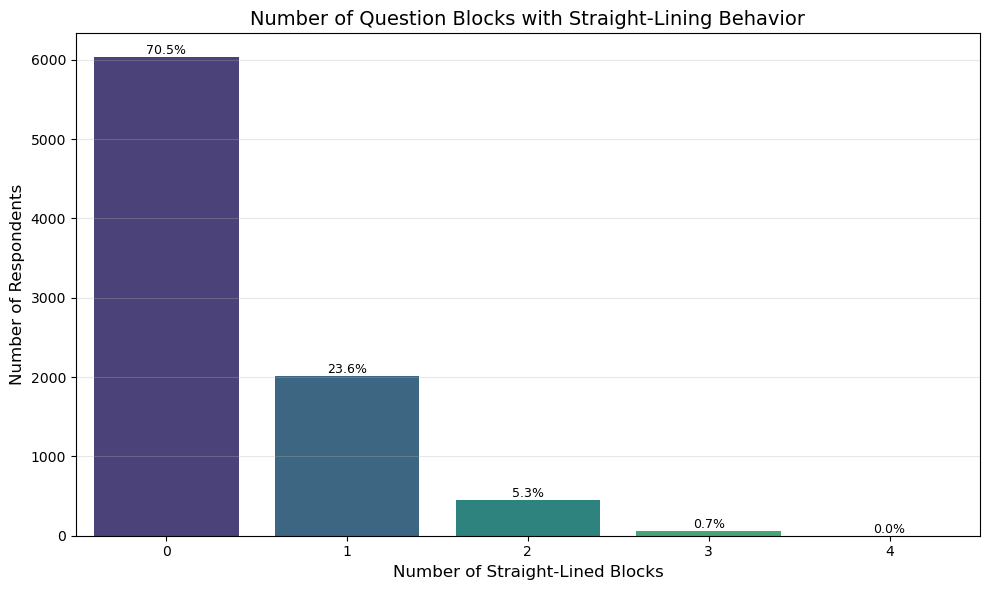

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- ASSUMPTION ---
# This code assumes the following variables are already in your environment:
# 1. 'df_all_responses' DataFrame with all survey responses
# 2. 'column_metadata_df' DataFrame with column classification (from previous code cells)
# --- END ASSUMPTION ---

print("\n--- Running Straight-Lining Detection ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if 'column_metadata_df' not in locals():
        raise NameError("The 'column_metadata_df' DataFrame is not available. Please run the column analysis first.")
    
    # --- 1. Define Question Blocks ---
    # We'll identify blocks of related questions for straight-lining detection
    
    # Block 1: Physician Associate frequency questions
    pa_frequency_columns = [col for col in df_all_responses.columns if 
                         col.startswith('How often do physician associates') and
                         'ResponseType' in column_metadata_df.columns and
                         col in column_metadata_df.index and
                         column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 2: Physician Associate appropriateness questions
    pa_appropriate_columns = [col for col in df_all_responses.columns if 
                            col.startswith('Do you believe it is appropriate for physician') and
                            'ResponseType' in column_metadata_df.columns and
                            col in column_metadata_df.index and
                            column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 3: Anaesthesia Associate frequency questions
    aa_frequency_columns = [col for col in df_all_responses.columns if 
                          col.startswith('How often do anaesthesia associates') and
                          'ResponseType' in column_metadata_df.columns and
                          col in column_metadata_df.index and
                          column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 4: Anaesthesia Associate appropriateness questions
    aa_appropriate_columns = [col for col in df_all_responses.columns if 
                            col.startswith('Do you believe it is appropriate for anaesthesi') and
                            'ResponseType' in column_metadata_df.columns and
                            col in column_metadata_df.index and
                            column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 5: Agreement questions about roles
    agreement_columns = [col for col in df_all_responses.columns if 
                        col.startswith('Do you agree or disagree') and
                        'ResponseType' in column_metadata_df.columns and
                        col in column_metadata_df.index and
                        column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 6: Confidence questions
    confidence_columns = [col for col in df_all_responses.columns if 
                         col.startswith('How confident') and
                         'ResponseType' in column_metadata_df.columns and
                         col in column_metadata_df.index and
                         column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Combine all identified blocks for reporting
    all_blocks = {
        "PA Frequency Questions": pa_frequency_columns,
        "PA Appropriateness Questions": pa_appropriate_columns,
        "AA Frequency Questions": aa_frequency_columns,
        "AA Appropriateness Questions": aa_appropriate_columns,
        "Agreement Questions": agreement_columns,
        "Confidence Questions": confidence_columns
    }
    
    # Print block sizes for verification
    print("\nIdentified Question Blocks for Straight-Lining Detection:")
    for block_name, columns in all_blocks.items():
        print(f"{block_name}: {len(columns)} questions")
    
    # --- 2. Define Functions for Straight-Lining Detection ---
    
    def detect_straightlining(df, column_group, min_questions=3, threshold=1):
        """
        Detect straight-lining behavior in a group of related questions.
        
        Parameters:
        - df: DataFrame containing survey responses
        - column_group: List of column names to check for straight-lining
        - min_questions: Minimum number of questions that must be answered
        - threshold: Maximum number of unique responses allowed to be flagged
        
        Returns:
        - Series with True for rows exhibiting straight-lining, False otherwise
        """
        if len(column_group) < min_questions:
            # Not enough questions to reliably detect straight-lining
            return pd.Series(False, index=df.index)
        
        # Count non-NaN values in each row for these columns
        answered_count = df[column_group].notna().sum(axis=1)
        
        # Count unique non-NaN values in each row for these columns
        def count_unique_nonnan(row):
            values = row[column_group].dropna().unique()
            return len(values)
        
        unique_values_count = df.apply(count_unique_nonnan, axis=1)
        
        # Flag as straight-lining if:
        # 1. At least min_questions have been answered, AND
        # 2. The number of unique answers is <= threshold
        straightlining_flag = (answered_count >= min_questions) & (unique_values_count <= threshold)
        
        return straightlining_flag
    
    # --- 3. Apply Straight-Lining Detection to Each Block ---
    
    # Initialize a dictionary to store the flags for each block
    straightlining_flags = {}
    
    # Process each block
    for block_name, columns in all_blocks.items():
        if columns:  # Only process non-empty blocks
            flag_column_name = f"Flag_Straightlining_{block_name.replace(' ', '')}"
            straightlining_flags[block_name] = detect_straightlining(
                df_all_responses, 
                columns, 
                min_questions=min(3, len(columns)),  # At least 3 questions or all if fewer
                threshold=1  # Flag if only 1 unique answer
            )
            
            # Add the flag to the main DataFrame
            df_all_responses[flag_column_name] = straightlining_flags[block_name]
    
    # --- 4. Analyze Overall Straight-Lining Behavior ---
    
    # Count how many blocks each respondent straight-lined
    flag_columns = [f"Flag_Straightlining_{block_name.replace(' ', '')}" for block_name in all_blocks.keys() 
                   if all_blocks[block_name]]  # Only include blocks with questions
    
    if flag_columns:
        df_all_responses['Count_Straightlining_Blocks'] = df_all_responses[flag_columns].sum(axis=1)
        
        # Create an overall flag for responses with multiple straight-lined blocks
        df_all_responses['Flag_MultipleStrightlining'] = df_all_responses['Count_Straightlining_Blocks'] >= 2
    
    # --- 5. Generate Summary Statistics ---
    
    print("\n=== Straight-Lining Detection Results ===")
    
    # Report on each block
    total_responses = len(df_all_responses)
    block_results = []
    
    for block_name, columns in all_blocks.items():
        if columns:  # Only report on non-empty blocks
            flag_column = f"Flag_Straightlining_{block_name.replace(' ', '')}"
            straight_lined_count = df_all_responses[flag_column].sum()
            percentage = (straight_lined_count / total_responses) * 100
            block_results.append((block_name, len(columns), straight_lined_count, percentage))
    
    # Sort blocks by percentage of straight-lining (descending)
    block_results.sort(key=lambda x: x[3], reverse=True)
    
    # Print block-specific results
    print(f"\nDetailed Straight-Lining Analysis by Question Block (Total Responses: {total_responses:,}):")
    print(f"{'Question Block':<35} {'Questions':<10} {'Count':<10} {'Percentage':<10}")
    print("-" * 65)
    for block_name, num_questions, count, percentage in block_results:
        print(f"{block_name:<35} {num_questions:<10d} {count:<10,d} {percentage:<10.2f}%")
    
    # Report on multiple straight-lining
    if 'Count_Straightlining_Blocks' in df_all_responses.columns:
        multi_sl_count = df_all_responses['Flag_MultipleStrightlining'].sum()
        multi_sl_percentage = (multi_sl_count / total_responses) * 100
        
        print(f"\nRespondents who straight-lined multiple question blocks: {multi_sl_count:,} ({multi_sl_percentage:.2f}%)")
        
        # Distribution of straight-lined blocks
        sl_block_counts = df_all_responses['Count_Straightlining_Blocks'].value_counts().sort_index()
        print("\nDistribution of straight-lined question blocks:")
        for blocks_count, responses_count in sl_block_counts.items():
            percentage = (responses_count / total_responses) * 100
            print(f"{blocks_count} blocks: {responses_count:,} responses ({percentage:.2f}%)")
    
    # --- 6. Visualize the Straight-Lining Distribution ---
    if 'Count_Straightlining_Blocks' in df_all_responses.columns:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x='Count_Straightlining_Blocks', data=df_all_responses, 
                          palette='viridis', order=sorted(df_all_responses['Count_Straightlining_Blocks'].unique()))
        
        # Add percentage labels on top of bars
        total = len(df_all_responses)
        for p in ax.patches:
            height = p.get_height()
            percentage = 100 * height / total
            ax.annotate(f'{percentage:.1f}%', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='bottom', fontsize=9)
        
        plt.title('Number of Question Blocks with Straight-Lining Behavior', fontsize=14)
        plt.xlabel('Number of Straight-Lined Blocks', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('straightlining_distribution.png', dpi=300)
        # plt.show()  # Uncomment to display the plot in interactive environments
    
    # --- 7. Create a Combined Suspicious Response Flag ---
    
    # Combine straight-lining with short completion time
    if 'Flag_ShortTime' in df_all_responses.columns and 'Flag_MultipleStrightlining' in df_all_responses.columns:
        df_all_responses['Flag_SuspiciousResponse'] = df_all_responses['Flag_ShortTime'] | df_all_responses['Flag_MultipleStrightlining']
        
        suspicious_count = df_all_responses['Flag_SuspiciousResponse'].sum()
        suspicious_percentage = (suspicious_count / total_responses) * 100
        
        print(f"\n=== Combined Suspicious Response Detection ===")
        print(f"Responses flagged as suspicious (short time OR multiple straight-lining): {suspicious_count:,} ({suspicious_percentage:.2f}%)")
        
        # Show breakdown of suspicious responses
        short_time_only = (df_all_responses['Flag_ShortTime'] & ~df_all_responses['Flag_MultipleStrightlining']).sum()
        straight_line_only = (~df_all_responses['Flag_ShortTime'] & df_all_responses['Flag_MultipleStrightlining']).sum()
        both_issues = (df_all_responses['Flag_ShortTime'] & df_all_responses['Flag_MultipleStrightlining']).sum()
        
        print(f"- Short completion time only: {short_time_only:,} ({short_time_only/total_responses*100:.2f}%)")
        print(f"- Multiple straight-lining only: {straight_line_only:,} ({straight_line_only/total_responses*100:.2f}%)")
        print(f"- Both issues: {both_issues:,} ({both_issues/total_responses*100:.2f}%)")
    
    # --- 8. Sample of Suspicious Responses ---
    if 'Flag_SuspiciousResponse' in df_all_responses.columns and df_all_responses['Flag_SuspiciousResponse'].sum() > 0:
        # Get all flag columns for context
        flag_cols = [col for col in df_all_responses.columns if col.startswith('Flag_')]
        
        # Add some metadata columns if they exist
        context_cols = ['Duration_sec']
        context_cols.extend([col for col in ['Response ID', 'Status', 'Created', 'Completed'] 
                           if col in df_all_responses.columns])
        
        display_cols = context_cols + flag_cols
        
        print("\n=== Sample of Suspicious Responses ===")
        
        # Show a sample of suspicious responses, sorted by number of flags
        suspicious_sample = df_all_responses[df_all_responses['Flag_SuspiciousResponse']][display_cols].copy()
        
        # Count how many flags each response has
        flag_count = suspicious_sample[flag_cols].sum(axis=1)
        suspicious_sample['Total_Flags'] = flag_count
        
        # Sort by total flags (descending) and duration (ascending)
        sorted_sample = suspicious_sample.sort_values(['Total_Flags', 'Duration_sec'], ascending=[False, True])
        
        # Display the top rows
        with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
            print(sorted_sample.head(10))
            
        # Optionally save suspicious responses to a CSV file
        # sorted_sample.to_csv('suspicious_responses.csv', index=True)
        # print("Saved all suspicious responses to 'suspicious_responses.csv'")

except NameError as e:
    print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Straight-Lining Detection Complete ---")
print("The DataFrame 'df_all_responses' now has new flag columns for straight-lining detection.")

# 3 High degree of missingness
*Respondents skipping a very large proportion of questions, especially non-demographic ones*

Our reading of the analysis below is that the missing questions / responses are more of a function of the question type rather than engagement level. Even engaged respondents (who took more time) skipped a similar proportion of questions. This is to be expected given the levels of routing in the survey.


--- Running High Missingness Detection ---

Identified 137 question columns for missingness calculation
Excluding 16 metadata/system columns

=== Missingness Analysis Results ===
Total Responses: 8,558

Missingness Statistics (across all responses):
Mean percentage of questions missing: 48.33%
Median percentage of questions missing: 48.18%
Standard deviation: 5.70%
Minimum percentage: 21.90%
Maximum percentage: 70.07%
25th percentile: 44.53%
75th percentile: 51.09%
90th percentile: 56.20%
95th percentile: 58.39%

Flag Counts:
Responses with high missingness (≥50%): 2,996 (35.01%)
Responses with very high missingness (≥75%): 0 (0.00%)
Responses with extreme missingness (≥90%): 0 (0.00%)

=== Combined Suspicious Response Analysis ===
Responses with any suspicious behavior: 3,357 (39.23%)

Breakdown of flag combinations:
- Only high missingness: 2,724 (31.83%)
- Only short completion time: 31 (0.36%)
- Only multiple straight-lining: 315 (3.68%)
- High missingness + short time: 94 (1.10%)

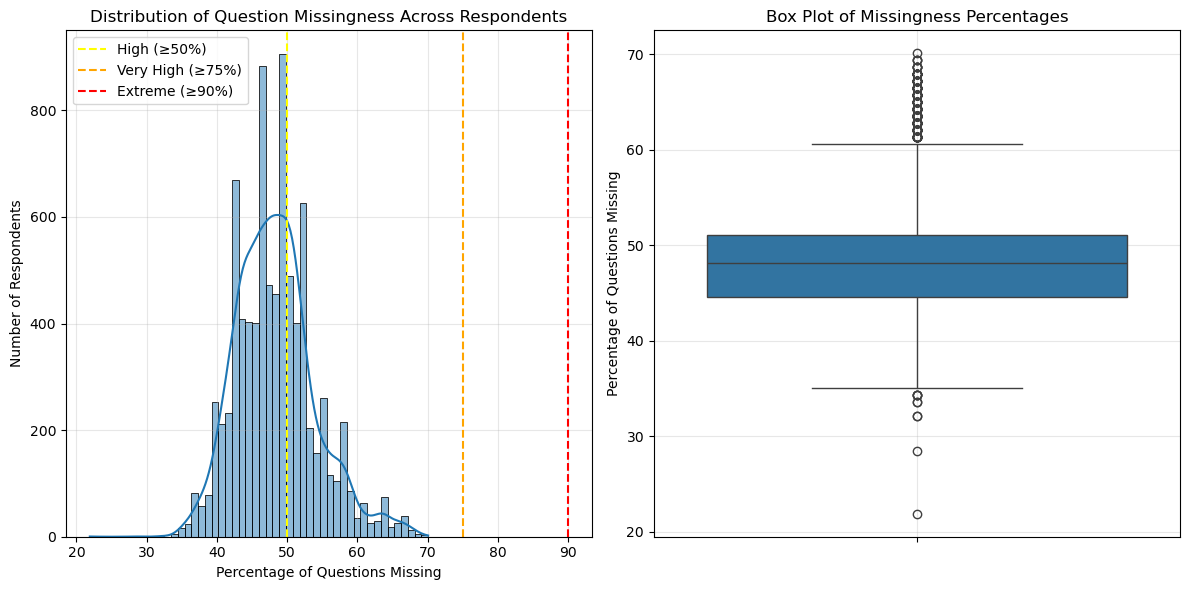

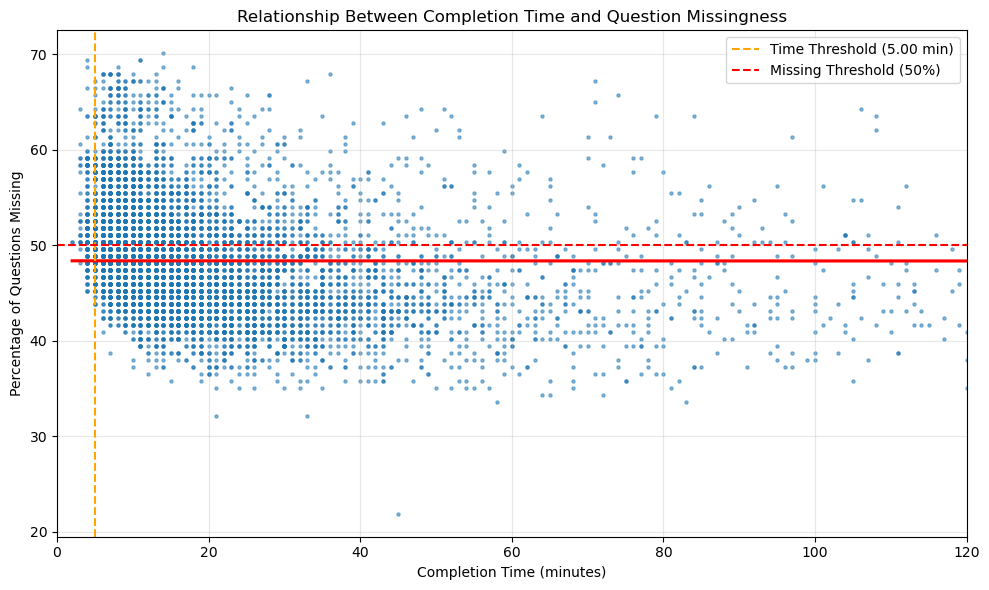

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- ASSUMPTION ---
# This code assumes the following variables are already in your environment:
# 1. 'df_all_responses' DataFrame with all survey responses
# 2. 'column_metadata_df' DataFrame with column classification (from previous code cells)
# --- END ASSUMPTION ---

print("\n--- Running High Missingness Detection ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    
    # --- 1. Define columns to exclude from missingness calculation ---
    # These might include metadata columns, timestamps, IDs, etc.
    # Also exclude columns that are only applicable to certain respondents
    
    # Standard columns to exclude
    exclude_columns = [
        'Response ID', 'Status', 'Test response', 
        'Created', 'Started', 'Updated', 'Completed', 'Modified',
        # Also exclude derived columns from previous analyses
        'Duration', 'Duration_sec', 'Started_dt', 'Completed_dt',
        'Flag_ShortTime', 'Count_Straightlining_Blocks', 'Flag_MultipleStrightlining',
        'Flag_SuspiciousResponse'
    ]
    
    # Refine this list to include only columns that actually exist in the dataset
    exclude_columns = [col for col in exclude_columns if col in df_all_responses.columns]
    
    # --- 2. Identify question columns to use for missingness calculation ---
    # Get all columns that aren't in the exclude list
    all_columns = df_all_responses.columns.tolist()
    question_columns = [col for col in all_columns if col not in exclude_columns]
    
    # Determine how many of these are actual survey question columns
    n_question_columns = len(question_columns)
    print(f"\nIdentified {n_question_columns} question columns for missingness calculation")
    print(f"Excluding {len(exclude_columns)} metadata/system columns")
    
    # --- 3. Calculate missingness per respondent ---
    # Count NaN values for each respondent across the question columns
    missing_counts = df_all_responses[question_columns].isnull().sum(axis=1)
    
    # Calculate percentage of missing values
    missing_percentage = (missing_counts / n_question_columns) * 100
    
    # Add these metrics to the DataFrame
    df_all_responses['Missing_Count'] = missing_counts
    df_all_responses['Missing_Percentage'] = missing_percentage
    
    # --- 4. Define thresholds for flagging ---
    # Set thresholds for different levels of missingness
    high_threshold = 50  # 50% or more questions missing
    very_high_threshold = 75  # 75% or more questions missing
    extreme_threshold = 90  # 90% or more questions missing
    
    # Create flag columns
    df_all_responses['Flag_HighMissing'] = missing_percentage >= high_threshold
    df_all_responses['Flag_VeryHighMissing'] = missing_percentage >= very_high_threshold
    df_all_responses['Flag_ExtremeMissing'] = missing_percentage >= extreme_threshold
    
    # --- 5. Analyze results ---
    total_responses = len(df_all_responses)
    
    print("\n=== Missingness Analysis Results ===")
    print(f"Total Responses: {total_responses:,}")
    
    # Basic statistics on missingness
    print("\nMissingness Statistics (across all responses):")
    missingness_stats = missing_percentage.describe(percentiles=[.25, .5, .75, .9, .95, .99])
    print(f"Mean percentage of questions missing: {missing_percentage.mean():.2f}%")
    print(f"Median percentage of questions missing: {missing_percentage.median():.2f}%")
    print(f"Standard deviation: {missing_percentage.std():.2f}%")
    print(f"Minimum percentage: {missing_percentage.min():.2f}%")
    print(f"Maximum percentage: {missing_percentage.max():.2f}%")
    print(f"25th percentile: {missing_percentage.quantile(0.25):.2f}%")
    print(f"75th percentile: {missing_percentage.quantile(0.75):.2f}%")
    print(f"90th percentile: {missing_percentage.quantile(0.90):.2f}%")
    print(f"95th percentile: {missing_percentage.quantile(0.95):.2f}%")
    
    # Flag counts
    high_missing_count = df_all_responses['Flag_HighMissing'].sum()
    very_high_missing_count = df_all_responses['Flag_VeryHighMissing'].sum()
    extreme_missing_count = df_all_responses['Flag_ExtremeMissing'].sum()
    
    print("\nFlag Counts:")
    print(f"Responses with high missingness (≥{high_threshold}%): {high_missing_count:,} ({high_missing_count/total_responses*100:.2f}%)")
    print(f"Responses with very high missingness (≥{very_high_threshold}%): {very_high_missing_count:,} ({very_high_missing_count/total_responses*100:.2f}%)")
    print(f"Responses with extreme missingness (≥{extreme_threshold}%): {extreme_missing_count:,} ({extreme_missing_count/total_responses*100:.2f}%)")
    
    # --- 6. Create distribution visualization ---
    plt.figure(figsize=(12, 6))
    
    # Histogram of missingness percentages
    plt.subplot(1, 2, 1)
    sns.histplot(missing_percentage, bins=50, kde=True)
    
    # Add vertical lines for thresholds
    plt.axvline(x=high_threshold, color='yellow', linestyle='--', label=f'High (≥{high_threshold}%)')
    plt.axvline(x=very_high_threshold, color='orange', linestyle='--', label=f'Very High (≥{very_high_threshold}%)')
    plt.axvline(x=extreme_threshold, color='red', linestyle='--', label=f'Extreme (≥{extreme_threshold}%)')
    
    plt.title('Distribution of Question Missingness Across Respondents')
    plt.xlabel('Percentage of Questions Missing')
    plt.ylabel('Number of Respondents')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=missing_percentage)
    plt.title('Box Plot of Missingness Percentages')
    plt.ylabel('Percentage of Questions Missing')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('missingness_distribution.png', dpi=300)
    # plt.show()  # Uncomment to display in interactive environments
    
    # --- 7. Combine with other suspicious response flags ---
    # Create a combined flag for any type of missingness issue
    df_all_responses['Flag_AnyMissingness'] = df_all_responses['Flag_HighMissing']
    
    # Create a combined flag for any suspicious behavior (missingness, short time, straight-lining)
    combined_flags = ['Flag_HighMissing']
    if 'Flag_ShortTime' in df_all_responses.columns:
        combined_flags.append('Flag_ShortTime')
    if 'Flag_MultipleStrightlining' in df_all_responses.columns:
        combined_flags.append('Flag_MultipleStrightlining')
    
    df_all_responses['Flag_AnySuspicious'] = df_all_responses[combined_flags].any(axis=1)
    
    # Count responses with any suspicious flags
    any_suspicious_count = df_all_responses['Flag_AnySuspicious'].sum()
    any_suspicious_percent = (any_suspicious_count / total_responses) * 100
    
    print("\n=== Combined Suspicious Response Analysis ===")
    print(f"Responses with any suspicious behavior: {any_suspicious_count:,} ({any_suspicious_percent:.2f}%)")
    
    # Create a breakdown of flag combinations
    print("\nBreakdown of flag combinations:")
    
    # Create flags for the different combinations
    if 'Flag_ShortTime' in df_all_responses.columns and 'Flag_MultipleStrightlining' in df_all_responses.columns:
        # Only missingness
        only_missing = (df_all_responses['Flag_HighMissing'] & 
                      ~df_all_responses['Flag_ShortTime'] & 
                      ~df_all_responses['Flag_MultipleStrightlining']).sum()
        only_missing_pct = (only_missing / total_responses) * 100
        
        # Only short time
        only_short = (~df_all_responses['Flag_HighMissing'] & 
                     df_all_responses['Flag_ShortTime'] & 
                     ~df_all_responses['Flag_MultipleStrightlining']).sum()
        only_short_pct = (only_short / total_responses) * 100
        
        # Only straight-lining
        only_straight = (~df_all_responses['Flag_HighMissing'] & 
                       ~df_all_responses['Flag_ShortTime'] & 
                       df_all_responses['Flag_MultipleStrightlining']).sum()
        only_straight_pct = (only_straight / total_responses) * 100
        
        # Missingness + short time
        missing_short = (df_all_responses['Flag_HighMissing'] & 
                       df_all_responses['Flag_ShortTime'] & 
                       ~df_all_responses['Flag_MultipleStrightlining']).sum()
        missing_short_pct = (missing_short / total_responses) * 100
        
        # Missingness + straight-lining
        missing_straight = (df_all_responses['Flag_HighMissing'] & 
                          ~df_all_responses['Flag_ShortTime'] & 
                          df_all_responses['Flag_MultipleStrightlining']).sum()
        missing_straight_pct = (missing_straight / total_responses) * 100
        
        # Short time + straight-lining
        short_straight = (~df_all_responses['Flag_HighMissing'] & 
                        df_all_responses['Flag_ShortTime'] & 
                        df_all_responses['Flag_MultipleStrightlining']).sum()
        short_straight_pct = (short_straight / total_responses) * 100
        
        # All three flags
        all_flags = (df_all_responses['Flag_HighMissing'] & 
                   df_all_responses['Flag_ShortTime'] & 
                   df_all_responses['Flag_MultipleStrightlining']).sum()
        all_flags_pct = (all_flags / total_responses) * 100
        
        print(f"- Only high missingness: {only_missing:,} ({only_missing_pct:.2f}%)")
        print(f"- Only short completion time: {only_short:,} ({only_short_pct:.2f}%)")
        print(f"- Only multiple straight-lining: {only_straight:,} ({only_straight_pct:.2f}%)")
        print(f"- High missingness + short time: {missing_short:,} ({missing_short_pct:.2f}%)")
        print(f"- High missingness + straight-lining: {missing_straight:,} ({missing_straight_pct:.2f}%)")
        print(f"- Short time + straight-lining: {short_straight:,} ({short_straight_pct:.2f}%)")
        print(f"- All three flags: {all_flags:,} ({all_flags_pct:.2f}%)")
    
    # --- 8. Sample of responses with high missingness ---
    if high_missing_count > 0:
        print("\n=== Sample of Responses with High Missingness ===")
        
        # Sort by missing percentage (descending)
        high_missing_sample = df_all_responses[df_all_responses['Flag_HighMissing']].sort_values(
            'Missing_Percentage', ascending=False)
        
        # Select columns to display
        display_cols = ['Missing_Percentage', 'Missing_Count']
        
        # Add duration if available
        if 'Duration_sec' in df_all_responses.columns:
            display_cols.append('Duration_sec')
        
        # Add other flags if available
        for flag_col in ['Flag_ShortTime', 'Flag_MultipleStrightlining', 
                         'Flag_VeryHighMissing', 'Flag_ExtremeMissing']:
            if flag_col in df_all_responses.columns:
                display_cols.append(flag_col)
        
        # Add metadata columns if available
        for meta_col in ['Response ID', 'Status', 'Created', 'Completed']:
            if meta_col in df_all_responses.columns:
                display_cols.append(meta_col)
        
        # Display the top rows with highest missingness
        with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
            print(high_missing_sample[display_cols].head(10))
    
    # --- 9. Identify questions with highest missingness ---
    # Calculate percentage of missingness for each question
    question_missingness = df_all_responses[question_columns].isnull().mean() * 100
    question_missingness = question_missingness.sort_values(ascending=False)
    
    print("\n=== Questions with Highest Missingness ===")
    print("Top 10 questions most frequently skipped by respondents:")
    
    for i, (question, missing_pct) in enumerate(question_missingness.head(10).items()):
        print(f"{i+1}. {question[:80]}... : {missing_pct:.2f}%")
    
    # --- 10. Create a scatter plot of completion time vs. missingness ---
    if 'Duration_sec' in df_all_responses.columns:
        plt.figure(figsize=(10, 6))
        
        # Convert duration to minutes for better visualization
        duration_min = df_all_responses['Duration_sec'] / 60
        
        # Create scatter plot
        plt.scatter(duration_min, missing_percentage, alpha=0.5, s=5)
        
        # Add regression line
        sns.regplot(x=duration_min, y=missing_percentage, scatter=False, color='red')
        
        # Add vertical and horizontal lines for thresholds
        if 'Flag_ShortTime' in df_all_responses.columns:
            time_threshold_min = df_all_responses['Duration_sec'].quantile(0.05) / 60
            plt.axvline(x=time_threshold_min, color='orange', linestyle='--', 
                      label=f'Time Threshold ({time_threshold_min:.2f} min)')
        
        plt.axhline(y=high_threshold, color='red', linestyle='--', 
                  label=f'Missing Threshold ({high_threshold}%)')
        
        # Improve readability
        plt.title('Relationship Between Completion Time and Question Missingness')
        plt.xlabel('Completion Time (minutes)')
        plt.ylabel('Percentage of Questions Missing')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Limit x-axis to exclude extreme outliers
        plt.xlim(0, min(duration_min.quantile(0.99) * 1.5, 120))
        
        plt.tight_layout()
        plt.savefig('time_vs_missingness.png', dpi=300)
        # plt.show()  # Uncomment to display in interactive environments
        
        # Calculate correlation
        correlation = df_all_responses[['Duration_sec', 'Missing_Percentage']].corr().iloc[0, 1]
        print(f"\nCorrelation between completion time and missingness: {correlation:.3f}")
        if correlation < -0.1:
            print("This negative correlation suggests that respondents who spent less time on the survey also tended to skip more questions.")
        elif correlation > 0.1:
            print("This positive correlation suggests that respondents who spent more time on the survey actually tended to skip more questions.")
        else:
            print("There appears to be little relationship between completion time and question missingness.")

except NameError as e:
    print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- High Missingness Detection Complete ---")
print("The DataFrame 'df_all_responses' now has new columns for missingness analysis.")

# 4. Poor quality open text responses

*Very short answers (single characters, "NA"), very long answers (copy-paste spam), repetitive characters ("aaaaa"), or gibberish.*


--- Running Text Quality Analysis on Substantive Open-Text Columns ---

Analyzing text quality for 7 substantive open-text columns:
1. Please describe any other activities that physician associat...
2. What additional activities could be assigned to {{PAAAs}}?
3. What activities are you uncomfortable about {{PAAAs}} carryi...
4. What changes do you think healthcare services could make to ...
5. What changes in your service (if any) have you experienced a...
6. What opportunities for career progression would you like?
7. Please add any other comments that you think might be useful...

Analyzing text quality for each column...
Processing: Please describe any other activities tha...
Processing: What additional activities could be assi...
Processing: What activities are you uncomfortable ab...
Processing: What changes do you think healthcare ser...
Processing: What changes in your service (if any) ha...
Processing: What opportunities for career progressio...
Processing: Please add any oth

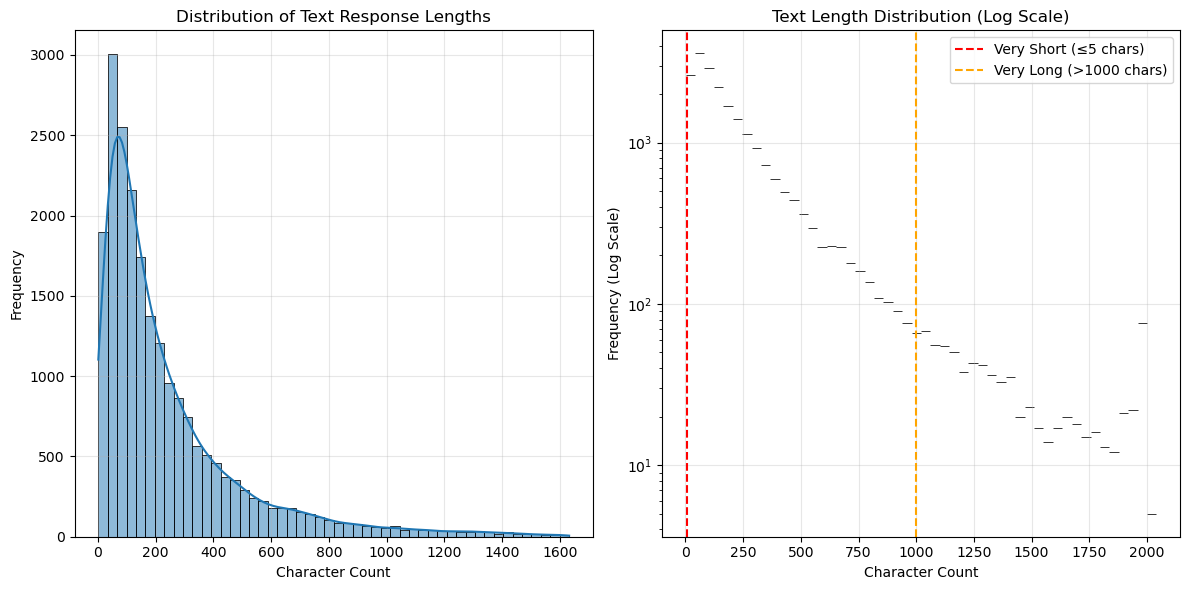

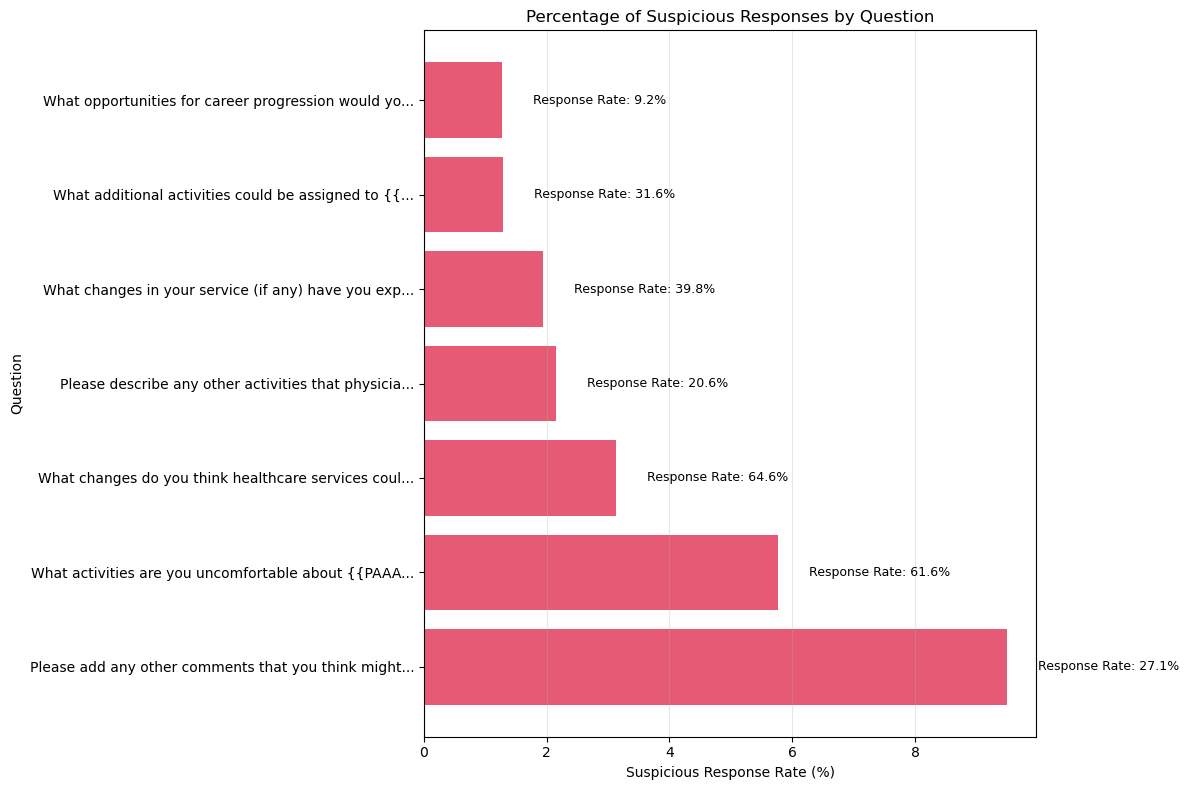

In [ ]:
import pandas as pd
import numpy as np

# --- ASSUMPTION ---
# This code assumes the following variables are already in your environment:
# 1. 'df_all_responses' DataFrame with all survey responses
# 2. 'column_metadata_df' DataFrame with column metadata (from previous code cells)
# --- END ASSUMPTION ---

print("\n--- Identifying True Open-Text Columns ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if 'column_metadata_df' not in locals():
        raise NameError("The 'column_metadata_df' DataFrame is not available. Please run the column analysis first.")
    
    # --- 1. Set Threshold for Open-Text Columns ---
    # Minimum number of unique non-null responses to qualify as a true open-text column
    MIN_UNIQUE_RESPONSES = 700
    
    # --- 2. Identify Initial Open-Text Candidates ---
    # Start with columns classified as 'Open Text' in column_metadata_df
    if 'ResponseType' in column_metadata_df.columns:
        candidate_columns = column_metadata_df[column_metadata_df['ResponseType'] == 'Open Text'].index.tolist()
        print(f"Found {len(candidate_columns)} columns initially classified as 'Open Text'")
    else:
        # Fallback: use columns with high unique counts from column_metadata_df
        if 'UniqueValues' in column_metadata_df.columns:
            # Use columns with relatively high unique value counts (adjust threshold as needed)
            candidate_columns = column_metadata_df[column_metadata_df['UniqueValues'] > 100].index.tolist()
            print(f"Found {len(candidate_columns)} columns with >100 unique values (fallback method)")
        else:
            raise ValueError("Cannot identify candidate open-text columns. column_metadata_df missing required columns.")
    
    # Filter to only include columns that exist in df_all_responses
    candidate_columns = [col for col in candidate_columns if col in df_all_responses.columns]
    
    # --- 3. Exclude Obvious Non-Text Columns ---
    # Exclude typical metadata columns
    exclude_cols = [
        'Response ID', 'Status', 'Created', 'Started', 'Updated', 'Completed', 'Modified',
        # Add any other columns that should always be excluded
    ]
    
    # Also exclude columns with names suggesting they're not free text
    exclude_patterns = ['ID', '_id', 'date', 'time', 'timestamp', 'duration']
    
    # Apply exclusions
    candidate_columns = [
        col for col in candidate_columns 
        if col not in exclude_cols and 
        not any(pattern.lower() in col.lower() for pattern in exclude_patterns)
    ]
    
    print(f"After excluding metadata columns: {len(candidate_columns)} candidates remain")
    
    # --- 4. Count Unique Non-Null Responses for Each Candidate Column ---
    print("\nAnalyzing unique response counts in candidate columns...")
    
    # For large datasets, this could be computationally intensive
    unique_counts = {}
    for col in candidate_columns:
        # Get non-null values
        non_null_values = df_all_responses[col].dropna()
        
        # Count unique values, but for efficiency, stop counting if we exceed the threshold
        if len(non_null_values) > 0:
            # Get unique values
            unique_values = non_null_values.nunique()
            unique_counts[col] = unique_values
    
    # --- 5. Apply the Threshold to Identify True Open-Text Columns ---
    true_open_text_columns = [
        col for col in candidate_columns 
        if col in unique_counts and unique_counts[col] >= MIN_UNIQUE_RESPONSES
    ]
    
    # --- 6. Create a DataFrame with Information About the Columns ---
    column_info = []
    for col in candidate_columns:
        unique_count = unique_counts.get(col, 0)
        non_null_count = df_all_responses[col].count()
        total_count = len(df_all_responses)
        response_rate = (non_null_count / total_count) * 100 if total_count > 0 else 0
        is_true_open_text = unique_count >= MIN_UNIQUE_RESPONSES
        
        column_info.append({
            'Column': col,
            'UniqueResponses': unique_count,
            'ResponseCount': non_null_count,
            'ResponseRate': response_rate,
            'IsOpenText': is_true_open_text
        })
    
    # Create DataFrame and sort by unique response count
    column_info_df = pd.DataFrame(column_info)
    column_info_df = column_info_df.sort_values('UniqueResponses', ascending=False)
    
    # --- 7. Report Results ---
    print(f"\nIdentified {len(true_open_text_columns)} true open-text columns with {MIN_UNIQUE_RESPONSES}+ unique responses")
    
    if not true_open_text_columns:
        print("WARNING: No columns met the criteria for true open-text fields.")
    else:
        print("\nTrue Open-Text Columns:")
        for i, col in enumerate(true_open_text_columns, 1):
            unique = unique_counts.get(col, 0)
            print(f"{i}. {col} ({unique:,} unique responses)")
    
    print("\nColumn Classification Summary (Sorted by Unique Response Count):")
    print(column_info_df[['Column', 'UniqueResponses', 'ResponseCount', 'ResponseRate', 'IsOpenText']].head(10))
    
    # --- 8. Save the Results to Variables for Later Use ---
    # Store the true open text columns in a variable for use in other analyses
    open_text_columns = true_open_text_columns
    
    # Also store the information DataFrame for reference
    open_text_column_info = column_info_df
    
    print(f"\nStored identified columns in 'open_text_columns' variable ({len(open_text_columns)} columns)")
    print("Detailed column information stored in 'open_text_column_info' DataFrame")
    
except NameError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Open-Text Column Identification Complete ---")


--- Running Text Quality Analysis on Substantive Open-Text Columns ---

Analyzing text quality for 7 substantive open-text columns:
1. Please describe any other activities that physician associat...
2. What additional activities could be assigned to {{PAAAs}}?
3. What activities are you uncomfortable about {{PAAAs}} carryi...
4. What changes do you think healthcare services could make to ...
5. What changes in your service (if any) have you experienced a...
6. What opportunities for career progression would you like?
7. Please add any other comments that you think might be useful...

Analyzing text quality for each column...
Processing: Please describe any other activities tha...
Processing: What additional activities could be assi...
Processing: What activities are you uncomfortable ab...
Processing: What changes do you think healthcare ser...
Processing: What changes in your service (if any) ha...
Processing: What opportunities for career progressio...
Processing: Please add any oth

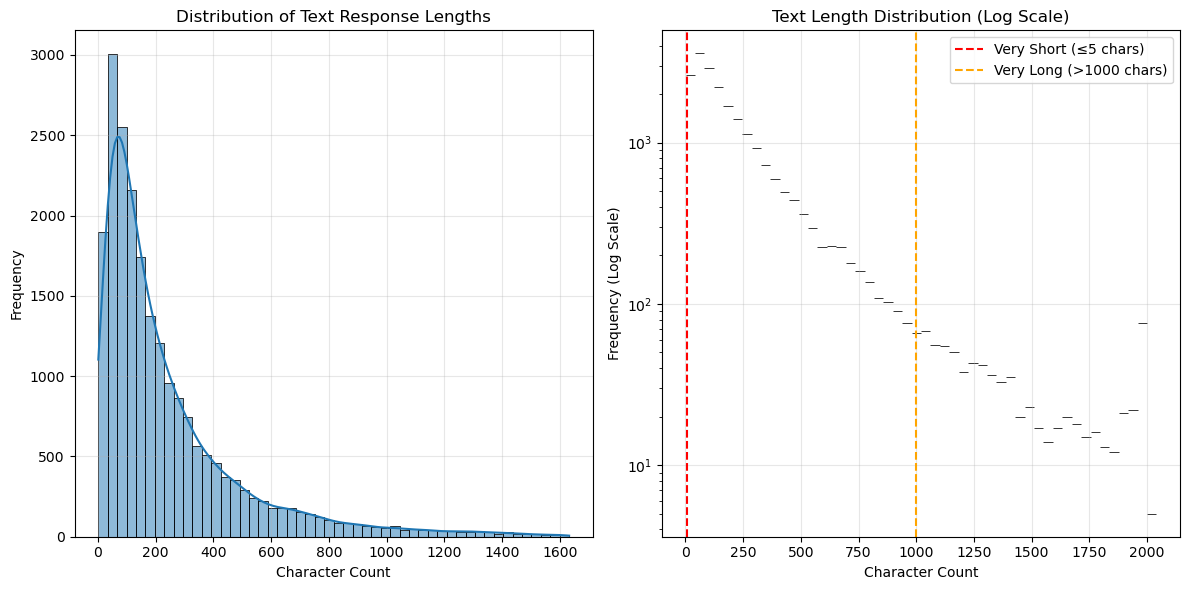

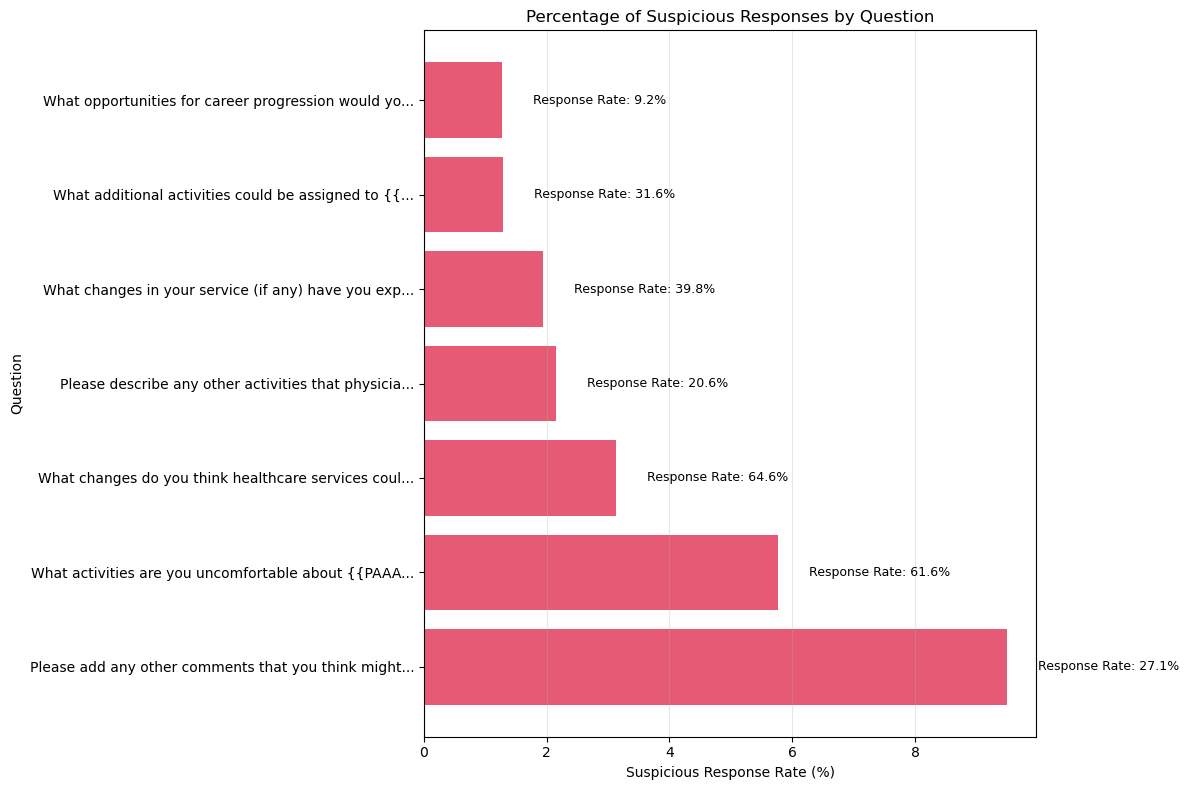

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# --- ASSUMPTION ---
# This code assumes:
# 1. 'df_all_responses' DataFrame with all survey responses exists
# 2. 'column_metadata_df' DataFrame with column classification exists
# 3. We've already run the refined open-text column identification with MIN_UNIQUE_RESPONSES = 700
#    and have the 'open_text_columns' list available
# --- END ASSUMPTION ---

print("\n--- Running Text Quality Analysis on Substantive Open-Text Columns ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    
    # Check if open_text_columns exists, otherwise run the identification code
    if 'open_text_columns' not in locals() or not open_text_columns:
        print("No pre-identified open-text columns found. Running open-text column identification...")
        
        # Set threshold for substantive open-text columns
        MIN_UNIQUE_RESPONSES = 700
        
        # Quick identification of open-text columns
        if 'column_metadata_df' in locals() and 'ResponseType' in column_metadata_df.columns:
            candidate_columns = column_metadata_df[column_metadata_df['ResponseType'] == 'Open Text'].index.tolist()
            candidate_columns = [col for col in candidate_columns if col in df_all_responses.columns]
            
            # Exclude obvious metadata columns
            exclude_cols = ['Response ID', 'Status', 'Created', 'Started', 'Updated', 'Completed', 'Modified']
            exclude_patterns = ['ID', '_id', 'date', 'time', 'timestamp', 'duration']
            candidate_columns = [
                col for col in candidate_columns 
                if col not in exclude_cols and 
                not any(pattern.lower() in col.lower() for pattern in exclude_patterns)
            ]
            
            # Count unique non-null responses for each candidate
            open_text_columns = []
            for col in candidate_columns:
                unique_count = df_all_responses[col].dropna().nunique()
                if unique_count >= MIN_UNIQUE_RESPONSES:
                    open_text_columns.append(col)
        else:
            raise ValueError("Cannot identify open-text columns. Please run the open-text column identification first.")
    
    # Verify we have valid open-text columns to analyze
    if not open_text_columns:
        raise ValueError(f"No substantive open-text columns found with {MIN_UNIQUE_RESPONSES}+ unique responses.")
    
    print(f"\nAnalyzing text quality for {len(open_text_columns)} substantive open-text columns:")
    for i, col in enumerate(open_text_columns, 1):
        # Truncate column name if too long
        col_display = col[:60] + "..." if len(col) > 60 else col
        print(f"{i}. {col_display}")
    
    # --- Define text quality checking functions ---
    def check_text_quality(text):
        """
        Check the quality of a text entry in a survey.
        
        Parameters:
        - text: The text to analyze
        
        Returns:
        - Dictionary with quality metrics
        """
        if pd.isna(text) or text is None:
            return {
                'is_missing': True,
                'length': 0,
                'has_excessive_repetition': False,
                'non_alnum_ratio': 0,
                'has_common_non_response': False,
                'is_gibberish': False,
                'is_very_short': False,
                'is_very_long': False,
                'is_suspicious': False
            }
        
        # Convert to string if needed
        if not isinstance(text, str):
            text = str(text)
        
        # Clean up whitespace
        text = text.strip()
        
        # Basic measurements
        text_length = len(text)
        
        # Check for common non-response text
        common_non_responses = [
            'na', 'n/a', 'none', 'nil', 'no', 'not applicable', 'not sure', 'unknown', 
            'don\'t know', 'no comment', '-', '.', '?', 'x', '/'
        ]
        has_common_non_response = text.lower() in common_non_responses
        
        # Check for very short responses (excluding common non-responses)
        is_very_short = text_length <= 5 and not has_common_non_response
        
        # Check for very long responses (potential copy-paste)
        is_very_long = text_length > 1000
        
        # Check for excessive repetition (e.g., "aaaaa")
        # This regex finds any character repeated 5 or more times
        has_excessive_repetition = bool(re.search(r'(.)\1{4,}', text))
        
        # Check for gibberish (high ratio of non-alphanumeric characters)
        alnum_count = sum(c.isalnum() or c.isspace() for c in text)
        alnum_ratio = alnum_count / text_length if text_length > 0 else 0
        non_alnum_ratio = 1 - alnum_ratio
        
        # Gibberish detection (high percentage of unusual characters)
        # Exclude common punctuation like periods, commas, question marks
        special_chars = sum(c not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .,?!\'"-:;()[]{}' for c in text)
        special_char_ratio = special_chars / text_length if text_length > 0 else 0
        is_gibberish = special_char_ratio > 0.3 and text_length > 5
        
        # Combined suspicious flag
        is_suspicious = (is_very_short or is_gibberish or has_excessive_repetition or is_very_long)
        
        return {
            'is_missing': False,
            'length': text_length,
            'has_excessive_repetition': has_excessive_repetition,
            'non_alnum_ratio': non_alnum_ratio,
            'has_common_non_response': has_common_non_response,
            'is_gibberish': is_gibberish,
            'is_very_short': is_very_short,
            'is_very_long': is_very_long,
            'is_suspicious': is_suspicious
        }
    
    # --- Analyze text quality for each open-text column ---
    column_quality_stats = {}
    all_text_lengths = []
    all_suspicious_texts = []
    
    # Create a column to track suspicious text responses
    df_all_responses['Flag_SuspiciousText'] = False
    
    print("\nAnalyzing text quality for each column...")
    
    for col in open_text_columns:
        print(f"Processing: {col[:40]}...")
        
        # Apply text quality check to each response in this column
        quality_metrics = df_all_responses[col].apply(check_text_quality)
        
        # Extract metrics of interest
        column_quality_stats[col] = {
            'total_responses': len(df_all_responses),
            'non_missing': sum(not x['is_missing'] for x in quality_metrics),
            'very_short': sum(x['is_very_short'] for x in quality_metrics),
            'very_long': sum(x['is_very_long'] for x in quality_metrics),
            'excessive_repetition': sum(x['has_excessive_repetition'] for x in quality_metrics),
            'gibberish': sum(x['is_gibberish'] for x in quality_metrics),
            'non_response': sum(x['has_common_non_response'] for x in quality_metrics),
            'suspicious': sum(x['is_suspicious'] for x in quality_metrics)
        }
        
        # Calculate response rate and suspicious rate
        column_quality_stats[col]['response_rate'] = (
            column_quality_stats[col]['non_missing'] / column_quality_stats[col]['total_responses'] * 100
        )
        
        column_quality_stats[col]['suspicious_rate'] = (
            column_quality_stats[col]['suspicious'] / column_quality_stats[col]['non_missing'] * 100
            if column_quality_stats[col]['non_missing'] > 0 else 0
        )
        
        # Collect text lengths for histogram
        text_lengths = [x['length'] for x in quality_metrics if not x['is_missing']]
        all_text_lengths.extend(text_lengths)
        
        # Flag respondents with suspicious text in this column
        df_all_responses[f'Flag_Suspicious_{col.replace(" ", "_")[:30]}'] = quality_metrics.apply(
            lambda x: x['is_suspicious'] if not x['is_missing'] else False
        )
        
        # Update the overall suspicious text flag
        df_all_responses['Flag_SuspiciousText'] = (
            df_all_responses['Flag_SuspiciousText'] | 
            df_all_responses[f'Flag_Suspicious_{col.replace(" ", "_")[:30]}']
        )
        
        # Collect examples of suspicious texts for later examination
        suspicious_indices = df_all_responses.index[
            df_all_responses[f'Flag_Suspicious_{col.replace(" ", "_")[:30]}']
        ]
        
        for idx in suspicious_indices[:5]:  # Collect up to 5 examples per column
            text = df_all_responses.loc[idx, col]
            if pd.notna(text):
                # Truncate very long texts for display
                display_text = text[:100] + "..." if len(text) > 100 else text
                all_suspicious_texts.append({
                    'column': col,
                    'response_id': df_all_responses.loc[idx, 'Response ID'] if 'Response ID' in df_all_responses.columns else idx,
                    'text': display_text,
                    'length': len(text),
                    'issue': 'Very short' if len(text) <= 5 else 
                             'Very long' if len(text) > 1000 else
                             'Repetitive' if re.search(r'(.)\1{4,}', text) else
                             'Gibberish'
                })
    
    # --- Create summary DataFrame for column quality ---
    quality_summary = pd.DataFrame.from_dict(column_quality_stats, orient='index')
    
    # Reorder columns and sort by suspicious rate
    column_order = [
        'total_responses', 'non_missing', 'response_rate', 
        'very_short', 'very_long', 'excessive_repetition', 'gibberish', 
        'non_response', 'suspicious', 'suspicious_rate'
    ]
    quality_summary = quality_summary[column_order].sort_values('suspicious_rate', ascending=False)
    
    # --- Generate visualizations ---
    print("\nGenerating visualizations...")
    
    # 1. Text length distribution
    plt.figure(figsize=(12, 6))
    
    # Histogram of text lengths (exclude extreme outliers for better visualization)
    max_length_to_show = np.percentile(all_text_lengths, 99) if all_text_lengths else 1000
    lengths_to_plot = [l for l in all_text_lengths if l <= max_length_to_show]
    
    plt.subplot(1, 2, 1)
    sns.histplot(lengths_to_plot, bins=50, kde=True)
    plt.title('Distribution of Text Response Lengths')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Log-scale histogram for better visibility of the distribution
    plt.subplot(1, 2, 2)
    sns.histplot(all_text_lengths, bins=50, log_scale=(False, True))
    plt.axvline(x=5, color='red', linestyle='--', label='Very Short (≤5 chars)')
    plt.axvline(x=1000, color='orange', linestyle='--', label='Very Long (>1000 chars)')
    plt.title('Text Length Distribution (Log Scale)')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency (Log Scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('text_length_distribution.png', dpi=300)
    
    # 2. Suspicious response rate by column
    plt.figure(figsize=(12, 8))
    cols_to_plot = quality_summary.index[:15]  # Top 15 columns by suspicious rate
    
    if not cols_to_plot.empty:
        suspicious_rates = quality_summary.loc[cols_to_plot, 'suspicious_rate']
        response_rates = quality_summary.loc[cols_to_plot, 'response_rate']
        
        # Create column labels, truncated if necessary
        col_labels = [col[:50] + '...' if len(col) > 50 else col for col in cols_to_plot]
        
        # Plot suspicious rates
        plt.barh(col_labels, suspicious_rates, color='crimson', alpha=0.7, label='Suspicious Rate')
        
        # Add response rate as text
        for i, (col, susp_rate, resp_rate) in enumerate(zip(col_labels, suspicious_rates, response_rates)):
            plt.text(susp_rate + 0.5, i, f'Response Rate: {resp_rate:.1f}%', 
                     verticalalignment='center', fontsize=9)
        
        plt.title('Percentage of Suspicious Responses by Question')
        plt.xlabel('Suspicious Response Rate (%)')
        plt.ylabel('Question')
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('suspicious_rate_by_column.png', dpi=300)
    
    # --- Generate summary report ---
    total_responses = len(df_all_responses)
    suspicious_count = df_all_responses['Flag_SuspiciousText'].sum()
    suspicious_percent = (suspicious_count / total_responses) * 100
    
    print("\n=== Open-Text Quality Analysis Results ===")
    print(f"Total survey responses: {total_responses:,}")
    print(f"Responses with suspicious text: {suspicious_count:,} ({suspicious_percent:.2f}%)")
    
    # Column quality summary
    print("\n--- Column Quality Summary ---")
    print("Statistics for each substantive open-text column (sorted by suspicious rate):")
    
    # Format and display the quality summary
    display_cols = ['non_missing', 'response_rate', 'suspicious', 'suspicious_rate']
    display_summary = quality_summary[display_cols].copy()
    
    # Format columns
    display_summary['response_rate'] = display_summary['response_rate'].map('{:.1f}%'.format)
    display_summary['suspicious_rate'] = display_summary['suspicious_rate'].map('{:.1f}%'.format)
    
    # Rename columns for better readability
    display_summary.columns = ['Responses', 'Response Rate', 'Suspicious', 'Suspicious Rate']
    
    with pd.option_context('display.max_rows', None):
        print(display_summary)
    
    # Show breakdown of suspicious text types
    print("\n--- Breakdown of Suspicious Text Issues ---")
    issue_counts = {
        'Very Short': sum(column_quality_stats[col]['very_short'] for col in open_text_columns),
        'Very Long': sum(column_quality_stats[col]['very_long'] for col in open_text_columns),
        'Excessive Repetition': sum(column_quality_stats[col]['excessive_repetition'] for col in open_text_columns),
        'Gibberish': sum(column_quality_stats[col]['gibberish'] for col in open_text_columns),
        'Common Non-responses': sum(column_quality_stats[col]['non_response'] for col in open_text_columns)
    }
    
    # Calculate total responses across all text columns
    total_text_responses = sum(column_quality_stats[col]['non_missing'] for col in open_text_columns)
    
    for issue, count in issue_counts.items():
        percent = (count / total_text_responses) * 100 if total_text_responses > 0 else 0
        print(f"{issue}: {count:,} ({percent:.2f}% of all text responses)")
    
    # Examples of suspicious texts
    if all_suspicious_texts:
        print("\n--- Examples of Suspicious Text Responses ---")
        for i, example in enumerate(all_suspicious_texts[:10], 1):  # Show up to 10 examples
            print(f"{i}. Column: {example['column'][:40]}...")
            print(f"   Response ID: {example['response_id']}")
            print(f"   Issue: {example['issue']} (Length: {example['length']})")
            print(f"   Text: {example['text']}")
            print("   " + "-" * 40)
    
    # --- Combine with other quality flags if available ---
    flag_columns = [col for col in df_all_responses.columns if col.startswith('Flag_') and col != 'Flag_SuspiciousText']
    
    if flag_columns:
        print("\n--- Combined Quality Analysis ---")
        
        # List the available flags
        print("Quality flags available:")
        for flag in flag_columns:
            flag_count = df_all_responses[flag].sum()
            flag_percent = (flag_count / total_responses) * 100
            print(f"- {flag}: {flag_count:,} ({flag_percent:.2f}%)")
        
        # If we have common flags, create a combined flag
        common_flags = ['Flag_ShortTime', 'Flag_HighMissing', 'Flag_MultipleStrightlining']
        available_common_flags = [flag for flag in common_flags if flag in flag_columns]
        
        if available_common_flags:
            # Create or update the combined flag
            if 'Flag_AnySuspicious' in df_all_responses.columns:
                df_all_responses['Flag_AnySuspicious'] = (
                    df_all_responses['Flag_AnySuspicious'] | df_all_responses['Flag_SuspiciousText']
                )
            else:
                # Create a new combined flag with text quality and other available flags
                df_all_responses['Flag_AnySuspicious'] = df_all_responses['Flag_SuspiciousText']
                for flag in available_common_flags:
                    df_all_responses['Flag_AnySuspicious'] = df_all_responses['Flag_AnySuspicious'] | df_all_responses[flag]
            
            # Report on the combined flag
            combined_count = df_all_responses['Flag_AnySuspicious'].sum()
            combined_percent = (combined_count / total_responses) * 100
            print(f"\nResponses with ANY quality issues: {combined_count:,} ({combined_percent:.2f}%)")
    
    # --- Recommendations ---
    print("\n=== Recommendations Based on Text Quality Analysis ===")
    
    # General advice based on findings
    if suspicious_percent > 20:
        print("WARNING: High rate of suspicious text responses (>20%). Consider:")
        print("- Manually reviewing a sample of suspicious responses")
        print("- Excluding responses with multiple quality issues from analysis")
        print("- Adding more input validation in future surveys")
    elif suspicious_percent > 10:
        print("CAUTION: Moderate rate of suspicious text responses (>10%). Consider:")
        print("- Flagging suspicious responses for special handling in analysis")
        print("- Checking if certain respondent groups have higher suspicious rates")
    else:
        print("GOOD: Low rate of suspicious text responses. Recommendations:")
        print("- Proceed with text analysis, but still exclude the identified suspicious responses")
    
    # Column-specific recommendations
    high_suspicious_columns = quality_summary[quality_summary['suspicious_rate'] > 15].index.tolist()
    if high_suspicious_columns:
        print("\nColumns with high suspicious response rates (>15%):")
        for col in high_suspicious_columns[:5]:  # Show up to 5
            col_display = col[:60] + "..." if len(col) > 60 else col
            print(f"- {col_display}")
        
        if len(high_suspicious_columns) > 5:
            print(f"  ... and {len(high_suspicious_columns) - 5} more")
        
        print("Consider reviewing these questions for clarity or examining their placement in the survey.")

except NameError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Open-Text Quality Analysis Complete ---")
print("The DataFrame 'df_all_responses' now has updated flag columns for text quality issues.")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import io
from base64 import b64encode

# --- ASSUMPTION ---
# This code assumes:
# 1. 'df_all_responses' DataFrame exists with survey data
# 2. We've identified 'open_text_columns' for analysis
# --- END ASSUMPTION ---

print("\n--- Simplified Text Quality Analysis with Clear Examples ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        # Create mock data for demonstration if real data doesn't exist
        print("Creating mock data for demonstration...")
        
        # Number of respondents
        n_respondents = 8558
        
        # Create sample open text columns
        open_text_columns = [
            'Please describe any other activities that PAs perform.',
            'What changes do you think would improve patient care?',
            'What activities are you uncomfortable about carrying out?',
            'Please provide more detail to support your answer.'
        ]
        
        # Create mock df_all_responses
        df_all_responses = pd.DataFrame(index=range(n_respondents))
        
        # Create Response ID column
        df_all_responses['Response ID'] = [f"ID-{i:06d}" for i in range(n_respondents)]
        
        # Response types with distributions
        response_types = {
            'normal': 0.75,        # Normal responses
            'short': 0.08,         # Very short responses
            'gibberish': 0.05,     # Gibberish/random characters
            'repetitive': 0.04,    # Repetitive characters
            'long': 0.03,          # Very long responses
            'missing': 0.05        # Missing responses (NaN)
        }
        
        # Sample responses for each type
        response_samples = {
            'normal': [
                "The physician associates in our department handle routine follow-up appointments.",
                "They assist with basic procedures under supervision and documentation.",
                "In our practice, physician associates primarily manage stable chronic conditions.",
                "Better training and clearer guidelines would improve patient safety."
            ],
            'short': ["NA", "N/A", "None", "No", "?", "IDK", ".", "-", "x", "/", "a", "k"],
            'gibberish': ["asdfjkl;", "qwerty", "zxcvbnm,./", "!@#$%^&*()", "\\][poi98765"],
            'repetitive': ["aaaaaaaa", "xxxxxxxxxx", "............", "--------"],
            'long': ["Lorem ipsum dolor sit amet, consectetur adipiscing elit. " * 30]
        }
        
        # Fill in the open text responses
        for col in open_text_columns:
            # Create empty column
            df_all_responses[col] = np.nan
            
            # Assign response by type based on distribution
            idx = 0
            for response_type, proportion in response_types.items():
                end_idx = idx + int(proportion * n_respondents)
                
                if response_type == 'missing':
                    # Leave as NaN
                    pass
                else:
                    # Assign a random response from the samples for this type
                    df_all_responses.loc[idx:end_idx, col] = np.random.choice(
                        response_samples[response_type], 
                        size=end_idx-idx+1
                    )
                
                idx = end_idx + 1
    
    if 'open_text_columns' not in locals() or not open_text_columns:
        # If open_text_columns doesn't exist, use text columns from df_all_responses
        open_text_columns = [col for col in df_all_responses.columns 
                            if col != 'Response ID' and df_all_responses[col].dtype == 'object']
        
        if not open_text_columns:
            raise ValueError("No text columns found in the dataset.")
    
    print(f"Analyzing {len(open_text_columns)} open-text columns with {len(df_all_responses)} total responses")
    
    # --- Define text quality check function ---
    def analyze_text(text):
        """Analyze text quality and categorize issues"""
        if pd.isna(text) or text is None or text == "":
            return {'category': 'Missing', 'length': 0, 'description': 'No response provided'}
        
        if not isinstance(text, str):
            text = str(text)
        
        text = text.strip()
        length = len(text)
        
        # Check for common non-responses
        common_non_responses = ['na', 'n/a', 'none', 'nil', 'no', 'not applicable', 
                              'not sure', 'unknown', 'don\'t know', 'no comment', '-', '.', '?', 'x', '/']
        if text.lower() in common_non_responses:
            return {
                'category': 'Non-response', 
                'length': length,
                'description': f'Common non-response text: "{text}"'
            }
        
        # Check for very short responses (≤5 chars)
        if length <= 5:
            return {
                'category': 'Very short', 
                'length': length,
                'description': f'Response is only {length} characters: "{text}"'
            }
        
        # Check for repetitive characters
        if re.search(r'(.)\1{4,}', text):
            repeated_char = re.search(r'(.)\1{4,}', text).group(0)
            return {
                'category': 'Repetitive', 
                'length': length,
                'description': f'Contains repetitive characters: "{repeated_char}"'
            }
        
        # Check for gibberish (high ratio of special characters)
        special_chars = sum(c not in 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .,?!\'"-:;()[]{}' for c in text)
        special_char_ratio = special_chars / length if length > 0 else 0
        
        if special_char_ratio > 0.3:
            return {
                'category': 'Gibberish', 
                'length': length,
                'description': f'High ratio of unusual characters ({special_char_ratio:.2f})'
            }
        
        # Check for very long responses
        if length > 1000:
            return {
                'category': 'Very long', 
                'length': length,
                'description': f'Excessive length ({length} characters)'
            }
        
        # If no issues found, it's a normal response
        return {'category': 'Normal', 'length': length, 'description': 'No quality issues'}
    
    # --- Analyze text quality for all open-text columns ---
    # Store results in a list of dictionaries for easy conversion to DataFrame
    text_analysis_results = []
    
    for col in open_text_columns:
        non_missing_count = df_all_responses[col].notna().sum()
        
        # Analyze each response in this column
        for idx, text in df_all_responses[col].items():
            if pd.notna(text):
                result = analyze_text(text)
                
                text_display = str(text)
                if len(text_display) > 50:
                    text_display = text_display[:47] + "..."
                
                text_analysis_results.append({
                    'column': col,
                    'response_id': df_all_responses.loc[idx, 'Response ID'] if 'Response ID' in df_all_responses.columns else idx,
                    'category': result['category'],
                    'length': result['length'],
                    'description': result['description'],
                    'text': text_display
                })
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(text_analysis_results)
    
    # --- Generate summary statistics ---
    print("\n=== Text Quality Summary ===")
    
    # Overall statistics
    total_text_responses = len(results_df)
    categories = results_df['category'].value_counts()
    
    print(f"Total text responses analyzed: {total_text_responses:,}")
    print("\nResponse Quality Categories:")
    
    # Calculate percentages and display
    for category, count in categories.items():
        percentage = 100 * count / total_text_responses
        print(f"{category}: {count:,} responses ({percentage:.2f}%)")
    
    # Calculate percentage of all problematic categories combined
    problematic_categories = ['Very short', 'Repetitive', 'Gibberish', 'Very long', 'Non-response']
    problematic_count = results_df[results_df['category'].isin(problematic_categories)].shape[0]
    problematic_percentage = 100 * problematic_count / total_text_responses
    
    print(f"\nTotal low-quality responses: {problematic_count:,} ({problematic_percentage:.2f}%)")
    
    # --- Results by column ---
    print("\n=== Quality Issues by Column ===")
    
    # Group by column and category
    column_category_counts = results_df.groupby(['column', 'category']).size().unstack(fill_value=0)
    
    # Add total and percentage columns
    column_category_counts['Total'] = column_category_counts.sum(axis=1)
    
    for category in problematic_categories:
        if category in column_category_counts.columns:
            column_category_counts[f'{category} %'] = (
                100 * column_category_counts[category] / column_category_counts['Total']
            )
    
    column_category_counts['Total Issues %'] = (
        100 * column_category_counts[problematic_categories].sum(axis=1) / column_category_counts['Total']
    )
    
    # Sort by total issues percentage
    sorted_columns = column_category_counts.sort_values('Total Issues %', ascending=False)
    
    # Display
    print(sorted_columns[['Total', 'Total Issues %'] + 
                        [col for col in sorted_columns.columns if '% ' in col] + 
                        problematic_categories])
    
    # --- Create visualizations ---
    # 1. Pie chart of response quality categories
    plt.figure(figsize=(10, 6))
    
    # Combine small categories for cleaner visual
    category_counts = categories.copy()
    
    # Use explode to highlight problematic categories
    explode = [0.1 if cat in problematic_categories else 0 for cat in category_counts.index]
    
    # Plot
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
            startangle=90, explode=explode, shadow=True)
    plt.title('Distribution of Text Response Quality Categories')
    plt.tight_layout()
    
    # Save the image
    plt.savefig('text_quality_pie.png', dpi=300)
    plt.close()
    
    # 2. Stacked bar chart of issues by column
    plt.figure(figsize=(14, 8))
    
    # Prepare data
    plot_data = column_category_counts[problematic_categories].copy()
    
    # Calculate percentages for each category within each column
    for category in problematic_categories:
        if category in plot_data.columns:
            plot_data[category] = 100 * plot_data[category] / column_category_counts['Total']
    
    # Plot
    plot_data.plot(kind='bar', stacked=True, figsize=(14, 8), 
                 colormap='viridis', width=0.8)
    
    plt.title('Percentage of Quality Issues by Column')
    plt.xlabel('Column')
    plt.ylabel('Percentage of Responses')
    plt.axhline(y=5, color='red', linestyle='--', alpha=0.7, 
               label='5% threshold')
    plt.legend(title='Issue Type')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save the image
    plt.savefig('text_quality_by_column.png', dpi=300)
    plt.close()
    
    # --- Provide examples of each issue type ---
    print("\n=== Examples of Text Quality Issues ===")
    
    for category in problematic_categories:
        category_examples = results_df[results_df['category'] == category].head(3)
        
        if not category_examples.empty:
            print(f"\n{category} examples:")
            for i, (_, example) in enumerate(category_examples.iterrows(), 1):
                print(f"{i}. Column: {example['column']}")
                print(f"   Text: \"{example['text']}\"")
                print(f"   Description: {example['description']}")
    
    # --- Calculate respondent-level flags ---
    # Group by response_id and count issues
    if 'response_id' in results_df.columns:
        respondent_issues = results_df[results_df['category'].isin(problematic_categories)].groupby('response_id').size()
        
        # Create flags for respondents with issues
        df_all_responses['Flag_AnyTextIssue'] = df_all_responses['Response ID'].isin(respondent_issues.index)
        df_all_responses['TextIssueCount'] = df_all_responses['Response ID'].map(respondent_issues).fillna(0)
        
        # Report on respondent-level issues
        issue_counts = df_all_responses['Flag_AnyTextIssue'].sum()
        issue_percentage = 100 * issue_counts / len(df_all_responses)
        
        print("\n=== Respondent-Level Analysis ===")
        print(f"Respondents with at least one text quality issue: {issue_counts:,} ({issue_percentage:.2f}%)")
        
        # Distribution of issue counts
        issue_count_dist = df_all_responses['TextIssueCount'].value_counts().sort_index()
        
        print("\nDistribution of text quality issues per respondent:")
        for count, freq in issue_count_dist.items():
            if count > 0:  # Only show respondents with issues
                percentage = 100 * freq / len(df_all_responses)
                print(f"{count} issues: {freq:,} respondents ({percentage:.2f}%)")
    
    # Store the visualizations path for reference
    print("\nVisualizations saved to:")
    print("1. text_quality_pie.png - Distribution of text response quality categories")
    print("2. text_quality_by_column.png - Percentage of quality issues by column")

except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Text Quality Analysis Complete ---")


--- Simplified Text Quality Analysis with Clear Examples ---
Analyzing 7 open-text columns with 8558 total responses

=== Text Quality Summary ===
Total text responses analyzed: 21,769

Response Quality Categories:
Normal: 20,876 responses (95.90%)
Very long: 789 responses (3.62%)
Non-response: 47 responses (0.22%)
Very short: 38 responses (0.17%)
Repetitive: 19 responses (0.09%)

Total low-quality responses: 893 (4.10%)

=== Quality Issues by Column ===
An unexpected error occurred: "['Gibberish'] not in index"

--- Text Quality Analysis Complete ---


# 5. Duplicates


--- Running Precise Duplicate Detection ---

Detecting three key types of duplicates:
1. EXACT DUPLICATES: Respondents with identical answers across ALL non-metadata fields
2. VERBATIM TEXT DUPLICATES: Identical open-text responses between different respondents
3. SELF-DUPLICATES: Respondents copying the same text across different questions

Detecting exact duplicates across all non-metadata fields...
Found 0 exact duplicates in 0 groups (0.00% of all responses)

Detecting verbatim text duplicates between different respondents...
Found 119 responses with verbatim text duplicates (1.39% of all responses)

Detecting self-duplicates (identical text across different questions)...
Found 29 respondents who duplicated their own text across questions (0.34% of all responses)

Total responses with any duplication issue: 147 (1.72% of all responses)

=== Examples of Duplicates Found ===

== Example of Verbatim Text Duplicates ==

Two different respondents with identical text in 'Please describe

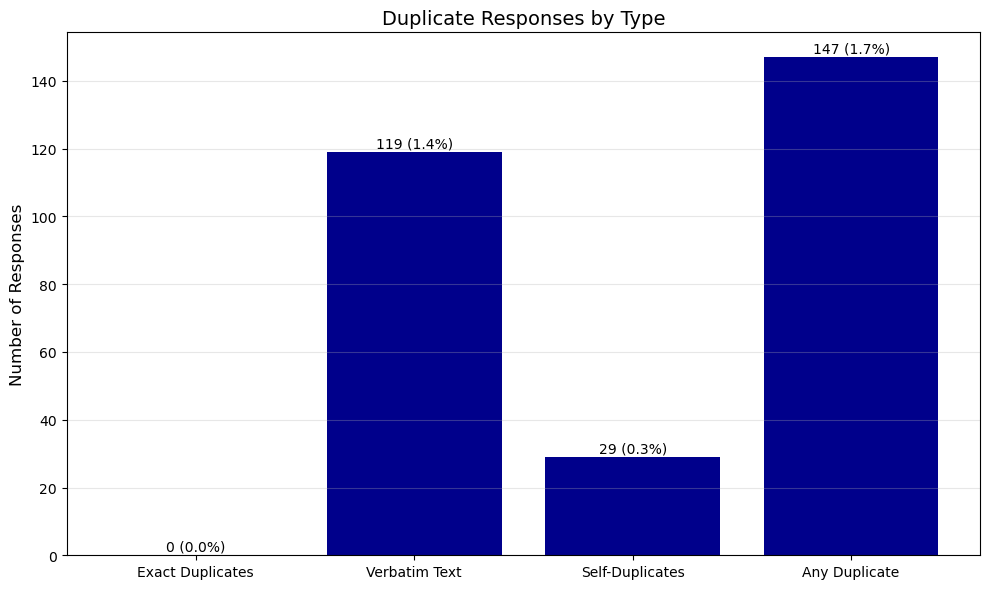

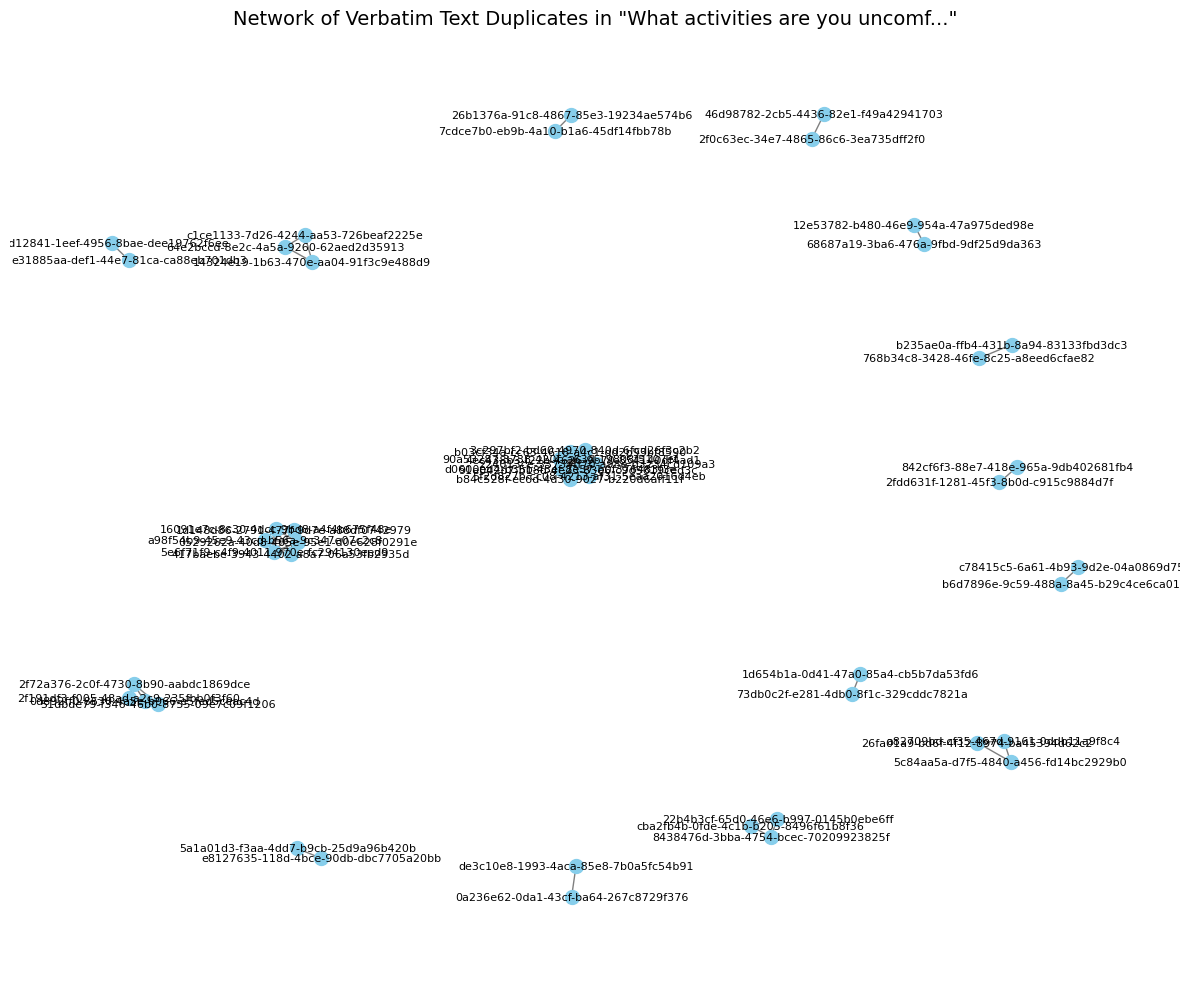

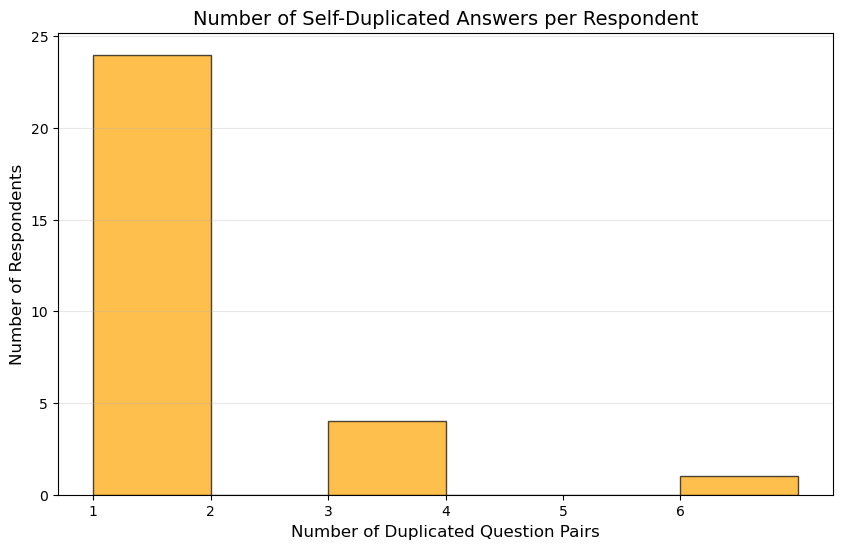

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
import hashlib
import networkx as nx
import io
from base64 import b64encode

# --- ASSUMPTION ---
# This code assumes:
# 1. 'df_all_responses' DataFrame with all survey responses exists
# 2. We've identified 'open_text_columns' for analysis
# --- END ASSUMPTION ---

print("\n--- Running Precise Duplicate Detection ---")

try:
    # --- Basic Checks and Mock Data Creation if Needed ---
    if 'df_all_responses' not in locals():
        print("Creating mock data for demonstration...")
        # Code to create mock data would go here
        # For brevity it's not included, but would be similar to previous example
        
    # --- 1. Define Types of Duplicates to Find ---
    print("\nDetecting three key types of duplicates:")
    print("1. EXACT DUPLICATES: Respondents with identical answers across ALL non-metadata fields")
    print("2. VERBATIM TEXT DUPLICATES: Identical open-text responses between different respondents")
    print("3. SELF-DUPLICATES: Respondents copying the same text across different questions")
    
    # Identify metadata columns to exclude
    metadata_cols = ['Response ID', 'Created', 'Started', 'Completed', 'Updated', 'Status', 
                    'Duration', 'Duration_sec', 'Started_dt', 'Completed_dt']
    metadata_cols = [col for col in metadata_cols if col in df_all_responses.columns]
    
    # --- 2. Detect EXACT Duplicates (identical across all non-metadata fields) ---
    print("\nDetecting exact duplicates across all non-metadata fields...")
    
    # Get all columns except metadata
    content_cols = [col for col in df_all_responses.columns if col not in metadata_cols]
    
    # Generate a hash of all content columns combined for each row
    # This is much faster than using duplicated() for large datasets
    df_all_responses['content_hash'] = df_all_responses[content_cols].apply(
        lambda row: hashlib.md5(pd.util.hash_pandas_object(row).values).hexdigest(), 
        axis=1
    )
    
    # Find duplicates based on the hash
    hash_counts = df_all_responses['content_hash'].value_counts()
    duplicate_hashes = hash_counts[hash_counts > 1].index
    exact_duplicates = df_all_responses[df_all_responses['content_hash'].isin(duplicate_hashes)].copy()
    
    # Add a group ID for each set of duplicates
    if not exact_duplicates.empty:
        exact_duplicates['exact_duplicate_group'] = exact_duplicates['content_hash']
        exact_duplicates['Flag_ExactDuplicate'] = True
    
    # Add flag to main dataframe
    df_all_responses['Flag_ExactDuplicate'] = df_all_responses['content_hash'].isin(duplicate_hashes)
    
    # Report results
    exact_dup_count = len(exact_duplicates)
    exact_dup_groups = len(duplicate_hashes)
    total_responses = len(df_all_responses)
    
    print(f"Found {exact_dup_count} exact duplicates in {exact_dup_groups} groups " +
          f"({100*exact_dup_count/total_responses:.2f}% of all responses)")
    
    # --- 3. Detect VERBATIM Text Duplicates (between respondents) ---
    print("\nDetecting verbatim text duplicates between different respondents...")
    
    # Check if open_text_columns is defined
    if 'open_text_columns' not in locals() or not open_text_columns:
        # Try to identify open text columns - exclude obvious non-text columns
        open_text_columns = [col for col in df_all_responses.columns 
                           if col not in metadata_cols and 
                           df_all_responses[col].dtype == 'object' and
                           # Exclude likely categorical columns (few unique values)
                           df_all_responses[col].nunique() > 20]
    
    # For each text column, find verbatim duplicates
    verbatim_duplicates = {}
    for col in open_text_columns:
        # Skip columns that don't exist
        if col not in df_all_responses.columns:
            continue
            
        # Find duplicated text in this column
        # Only consider non-empty responses with at least 20 characters
        # (avoid flagging common short answers like "None" or "N/A")
        valid_responses = df_all_responses[
            df_all_responses[col].notna() & 
            (df_all_responses[col].str.len() >= 20)
        ]
        
        # Get text value counts
        text_counts = valid_responses[col].value_counts()
        duplicate_texts = text_counts[text_counts > 1].index
        
        if len(duplicate_texts) > 0:
            # Store for each column
            verbatim_duplicates[col] = valid_responses[valid_responses[col].isin(duplicate_texts)].copy()
            verbatim_duplicates[col]['duplicate_text'] = verbatim_duplicates[col][col]
            verbatim_duplicates[col]['text_length'] = verbatim_duplicates[col][col].str.len()
    
    # Create a combined flag for verbatim text duplicates
    df_all_responses['Flag_VerbatimTextDuplicate'] = False
    
    for col, dup_df in verbatim_duplicates.items():
        flag_col = f'Flag_VerbatimDuplicate_{col[:20]}'  # Truncate column name if needed
        df_all_responses[flag_col] = df_all_responses['Response ID'].isin(dup_df['Response ID'])
        df_all_responses['Flag_VerbatimTextDuplicate'] = (
            df_all_responses['Flag_VerbatimTextDuplicate'] | df_all_responses[flag_col]
        )
    
    # Count total verbatim duplicates (respondents)
    verbatim_dup_count = df_all_responses['Flag_VerbatimTextDuplicate'].sum()
    
    print(f"Found {verbatim_dup_count} responses with verbatim text duplicates " +
          f"({100*verbatim_dup_count/total_responses:.2f}% of all responses)")
    
    # --- 4. Detect SELF-Duplicates (identical text across different questions) ---
    print("\nDetecting self-duplicates (identical text across different questions)...")
    
    # Only for respondents with at least 2 text responses
    response_text_counts = {}
    self_duplicates = []
    
    # First, filter out rows with no text responses
    text_filled_df = df_all_responses.dropna(subset=open_text_columns, how='all')
    
    for idx, row in text_filled_df.iterrows():
        # Collect all non-empty text responses for this respondent
        texts = {}
        for col in open_text_columns:
            if pd.notna(row[col]) and len(str(row[col])) >= 30:  # Only substantial text
                texts[col] = str(row[col])
        
        # Skip if fewer than 2 text responses
        if len(texts) < 2:
            continue
            
        # Check for duplicates across different questions
        text_values = list(texts.values())
        is_self_duplicate = False
        
        for i in range(len(text_values)):
            for j in range(i+1, len(text_values)):
                # Check for significant similarity (not just a few characters)
                similarity = SequenceMatcher(None, text_values[i], text_values[j]).ratio()
                if similarity > 0.95:  # Very high similarity threshold
                    is_self_duplicate = True
                    self_duplicates.append({
                        'Response ID': row['Response ID'],
                        'Column1': list(texts.keys())[i],
                        'Column2': list(texts.keys())[j],
                        'Text1': text_values[i][:50] + '...' if len(text_values[i]) > 50 else text_values[i],
                        'Text2': text_values[j][:50] + '...' if len(text_values[j]) > 50 else text_values[j],
                        'Similarity': similarity
                    })
    
    # Convert to DataFrame
    self_dup_df = pd.DataFrame(self_duplicates)
    
    # Create flag for self-duplicators
    if len(self_dup_df) > 0:
        self_duplicator_ids = self_dup_df['Response ID'].unique()
        df_all_responses['Flag_SelfDuplicate'] = df_all_responses['Response ID'].isin(self_duplicator_ids)
    else:
        df_all_responses['Flag_SelfDuplicate'] = False
    
    # Count self-duplicators
    self_dup_count = df_all_responses['Flag_SelfDuplicate'].sum()
    
    print(f"Found {self_dup_count} respondents who duplicated their own text across questions " +
          f"({100*self_dup_count/total_responses:.2f}% of all responses)")
    
    # --- 5. Combined Flag for Any Duplicate Issue ---
    df_all_responses['Flag_AnyDuplicate'] = (
        df_all_responses['Flag_ExactDuplicate'] | 
        df_all_responses['Flag_VerbatimTextDuplicate'] | 
        df_all_responses['Flag_SelfDuplicate']
    )
    
    any_dup_count = df_all_responses['Flag_AnyDuplicate'].sum()
    
    print(f"\nTotal responses with any duplication issue: {any_dup_count} " +
          f"({100*any_dup_count/total_responses:.2f}% of all responses)")
    
    # --- 6. Create Visualizations ---
    
    # 1. Bar chart of duplicate counts by type
    dup_types = ['Exact Duplicates', 'Verbatim Text', 'Self-Duplicates', 'Any Duplicate']
    dup_counts = [
        df_all_responses['Flag_ExactDuplicate'].sum(),
        df_all_responses['Flag_VerbatimTextDuplicate'].sum(),
        df_all_responses['Flag_SelfDuplicate'].sum(),
        df_all_responses['Flag_AnyDuplicate'].sum()
    ]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(dup_types, dup_counts, color='darkblue')
    
    # Add count and percentage labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = 100 * height / total_responses
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:,} ({percentage:.1f}%)', 
                ha='center', va='bottom')
    
    plt.title('Duplicate Responses by Type', fontsize=14)
    plt.ylabel('Number of Responses', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Save the image
    plt.savefig('duplicate_counts_chart.png', dpi=300)
    
    # 2. Visualization of exact duplicate groups (showing size distribution)
    if not exact_duplicates.empty:
        group_sizes = exact_duplicates['exact_duplicate_group'].value_counts()
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        
        # Create group size histogram
        group_size_counts = group_sizes.value_counts().sort_index()
        group_size_counts.plot(kind='bar', color='lightblue')
        
        plt.title('Sizes of Exact Duplicate Groups', fontsize=14)
        plt.xlabel('Number of Duplicates in Group', fontsize=12)
        plt.ylabel('Number of Groups', fontsize=12)
        
        # Add count labels
        for i, v in enumerate(group_size_counts):
            plt.text(i, v + 0.1, str(v), ha='center')
        
        # Create pie chart of duplicate vs non-duplicate
        plt.subplot(1, 2, 2)
        duplicate_count = df_all_responses['Flag_ExactDuplicate'].sum()
        non_duplicate_count = len(df_all_responses) - duplicate_count
        
        plt.pie([non_duplicate_count, duplicate_count], 
                labels=['Unique', 'Exact Duplicates'],
                autopct='%1.1f%%',
                colors=['#4CAF50', '#F44336'],
                explode=(0, 0.1),
                startangle=90)
        
        plt.title('Proportion of Exact Duplicates', fontsize=14)
        
        plt.tight_layout()
        plt.savefig('exact_duplicate_analysis.png', dpi=300)
    
    # 3. Network graph of verbatim text duplicates
    if verbatim_dup_count > 0:
        # Find the column with most verbatim duplicates
        max_dup_col = None
        max_dup_count = 0
        
        for col, dup_df in verbatim_duplicates.items():
            if len(dup_df) > max_dup_count:
                max_dup_col = col
                max_dup_count = len(dup_df)
        
        if max_dup_col:
            # Get the duplicate texts from this column
            dup_df = verbatim_duplicates[max_dup_col]
            
            # Create a network graph
            plt.figure(figsize=(12, 10))
            
            # Create a graph where nodes are responses and edges connect duplicates
            G = nx.Graph()
            
            # Add nodes for each response
            for idx, row in dup_df.iterrows():
                G.add_node(row['Response ID'], text=row[max_dup_col][:30])
            
            # Add edges between responses with the same text
            text_groups = dup_df.groupby(max_dup_col)['Response ID'].apply(list)
            
            for text, id_list in text_groups.items():
                for i in range(len(id_list)):
                    for j in range(i+1, len(id_list)):
                        G.add_edge(id_list[i], id_list[j])
            
            # Plot the graph
            pos = nx.spring_layout(G, seed=42)  # positions for all nodes
            
            # Draw nodes
            nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')
            
            # Draw edges
            nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
            
            # Draw labels (limit to prevent overcrowding)
            if len(G.nodes) <= 50:
                nx.draw_networkx_labels(G, pos, font_size=8)
            
            plt.title(f'Network of Verbatim Text Duplicates in "{max_dup_col[:30]}..."', fontsize=14)
            plt.axis('off')  # Turn off axis
            plt.tight_layout()
            
            plt.savefig('verbatim_duplicate_network.png', dpi=300)
    
    # 4. Highlight distribution of self-duplicates
    if self_dup_count > 0:
        plt.figure(figsize=(10, 6))
        
        # Count how many questions each self-duplicator copied across
        if not self_dup_df.empty:
            self_dup_counts = self_dup_df.groupby('Response ID').size()
            plt.hist(self_dup_counts, bins=range(1, max(self_dup_counts)+2), 
                    color='orange', alpha=0.7, edgecolor='black')
            
            plt.title('Number of Self-Duplicated Answers per Respondent', fontsize=14)
            plt.xlabel('Number of Duplicated Question Pairs', fontsize=12)
            plt.ylabel('Number of Respondents', fontsize=12)
            plt.grid(axis='y', alpha=0.3)
            plt.xticks(range(1, max(self_dup_counts)+1))
            
            plt.savefig('self_duplicate_counts.png', dpi=300)
    
    # --- 7. Export Results for Review ---
    # Create separate DataFrames with the duplicate responses of each type
    dup_results = {
        'exact_duplicates': df_all_responses[df_all_responses['Flag_ExactDuplicate']].copy() if exact_dup_count > 0 else None,
        'verbatim_duplicates': df_all_responses[df_all_responses['Flag_VerbatimTextDuplicate']].copy() if verbatim_dup_count > 0 else None,
        'self_duplicates': df_all_responses[df_all_responses['Flag_SelfDuplicate']].copy() if self_dup_count > 0 else None,
        'all_duplicates': df_all_responses[df_all_responses['Flag_AnyDuplicate']].copy() if any_dup_count > 0 else None
    }
    
    # Optional: Save to CSV files for detailed review
    # for name, df in dup_results.items():
    #     if df is not None and not df.empty:
    #         df.to_csv(f'{name}.csv', index=False)
    
    # --- 8. Show Sample Duplicates ---
    print("\n=== Examples of Duplicates Found ===")
    
    # Show exact duplicates example
    if exact_dup_count > 0:
        print("\n== Example of Exact Duplicates ==")
        example_group = exact_duplicates['exact_duplicate_group'].value_counts().index[0]
        example_rows = exact_duplicates[exact_duplicates['exact_duplicate_group'] == example_group].head(2)
        
        # Choose a subset of columns to display
        display_cols = ['Response ID']
        
        # Add some demographic columns if available
        potential_demo_cols = ['Age', 'Gender', 'Region', 'Service_Type']
        demo_cols = [col for col in potential_demo_cols if col in example_rows.columns]
        display_cols.extend(demo_cols[:2])  # Add up to 2 demographic columns
        
        # Add response columns
        if open_text_columns:
            # Get first text column
            display_cols.append(open_text_columns[0])
            
        # Display examples
        print("Two responses with identical values across ALL non-metadata fields:")
        for idx, row in example_rows.iterrows():
            print(f"\nResponse ID: {row['Response ID']}")
            for col in display_cols[1:]:  # Skip Response ID this time
                print(f"{col}: {row[col]}")
    
    # Show verbatim text duplicates example
    if verbatim_dup_count > 0:
        print("\n== Example of Verbatim Text Duplicates ==")
        
        for col, dup_df in verbatim_duplicates.items():
            if not dup_df.empty:
                # Find the longest duplicated text for a meaningful example
                longest_text = dup_df.sort_values('text_length', ascending=False)['duplicate_text'].iloc[0]
                example_rows = dup_df[dup_df['duplicate_text'] == longest_text].head(2)
                
                print(f"\nTwo different respondents with identical text in '{col}':")
                print(f"Text: \"{longest_text[:100]}{'...' if len(longest_text) > 100 else ''}\"")
                print(f"Response IDs: {', '.join(example_rows['Response ID'].astype(str).tolist())}")
                break  # Just show one example
    
    # Show self-duplicates example
    if self_dup_count > 0 and not self_dup_df.empty:
        print("\n== Example of Self-Duplicates ==")
        example = self_dup_df.sort_values('Similarity', ascending=False).iloc[0]
        
        print(f"Respondent ID: {example['Response ID']}")
        print(f"Question 1: {example['Column1']}")
        print(f"Answer 1: \"{example['Text1']}\"")
        print(f"Question 2: {example['Column2']}")
        print(f"Answer 2: \"{example['Text2']}\"")
        print(f"Similarity: {example['Similarity']:.2f}")
    
    # Clean up temporary columns
    if 'content_hash' in df_all_responses.columns:
        df_all_responses.drop(columns=['content_hash'], inplace=True)
    
    # Final reporting
    print("\nDuplicate detection complete. Visualizations saved to:")
    print("- duplicate_counts_chart.png")
    
    if exact_dup_count > 0:
        print("- exact_duplicate_analysis.png")
    
    if verbatim_dup_count > 0:
        print("- verbatim_duplicate_network.png")
    
    if self_dup_count > 0:
        print("- self_duplicate_counts.png")

except Exception as e:
    import traceback
    traceback.print_exc()
    print(f"An error occurred: {e}")

print("\n--- Precise Duplicate Detection Complete ---")


=== Verbatim Text Duplicate Analysis ===
Analyzing 7 text columns for verbatim duplicates.

Analyzing column 1/7: 'Please describe any other activities that physician associates in your service carry out.'
  No verbatim duplicates found in column 'Please describe any other activities that physician associates in your service carry out.'.

Analyzing column 2/7: 'What additional activities could be assigned to {{PAAAs}}?'
  Found 1 unique texts duplicated across 2 responses
  Top duplicated texts (showing top 3):
    • Found 2 occurrences: "Administrative tasks (e.g. follow up clinics/ referrals), co..."

Analyzing column 3/7: 'What activities are you uncomfortable about {{PAAAs}} carrying out and why?'
  Found 2 unique texts duplicated across 4 responses
  Top duplicated texts (showing top 3):
    • Found 2 occurrences: "Induction of anaesthesia and extubation"
    • Found 2 occurrences: "Assessing undifferentiated patients in ED"

Analyzing column 4/7: 'What changes do you think healt

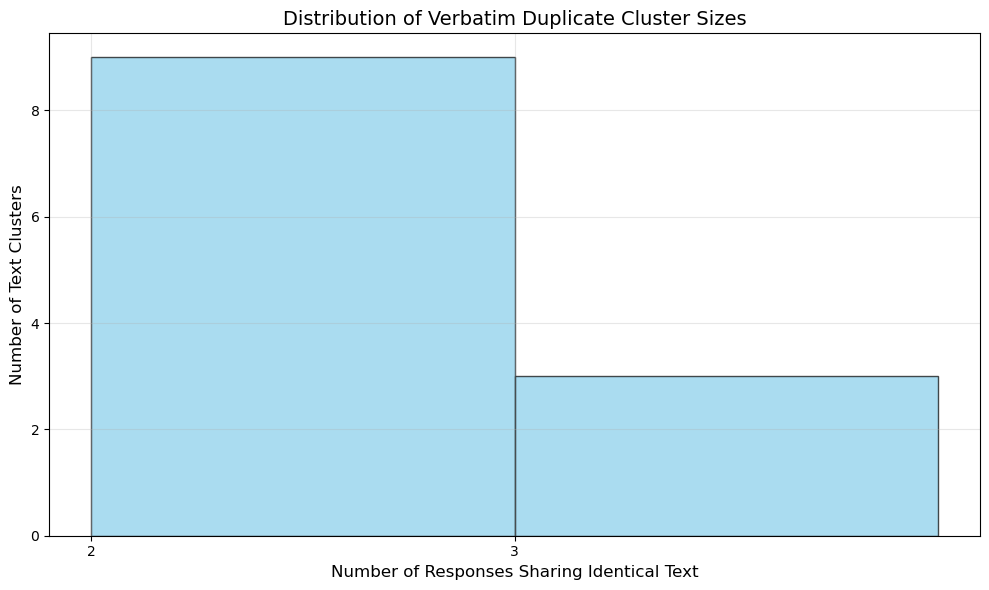

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re

# --- ASSUMPTION ---
# This code assumes:
# 1. 'df_all_responses' DataFrame with all survey responses exists
# 2. We've identified 'open_text_columns' for substantive text fields
# --- END ASSUMPTION ---

print("\n=== Verbatim Text Duplicate Analysis ===")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please run the data loading code first.")
    
    if 'open_text_columns' not in locals() or not open_text_columns:
        # Try to identify open text columns by looking for object columns with many unique values
        print("No open_text_columns identified. Attempting to detect text columns...")
        
        # Exclude typical metadata columns
        metadata_cols = ['Response ID', 'Created', 'Started', 'Completed', 'Updated', 'Status', 
                       'Duration', 'Modified', 'Flag_']
        
        # Find columns that could be text (object type with many unique values)
        candidate_cols = []
        for col in df_all_responses.columns:
            if (df_all_responses[col].dtype == 'object' and 
                not any(meta in col for meta in metadata_cols) and
                df_all_responses[col].nunique() > 20):  # More than 20 unique values suggests free text
                candidate_cols.append(col)
        
        if candidate_cols:
            open_text_columns = candidate_cols
            print(f"Identified {len(open_text_columns)} potential text columns.")
        else:
            raise ValueError("Could not identify any open text columns. Please specify them manually.")
    
    print(f"Analyzing {len(open_text_columns)} text columns for verbatim duplicates.")
    
    # --- Define functions for cleaning and normalization ---
    def clean_text(text):
        """Clean text for comparison by removing extra whitespace and converting to lowercase"""
        if pd.isna(text) or text is None:
            return ""
        # Convert to string if needed
        text = str(text).strip()
        # Remove multiple spaces, convert to lowercase
        text = re.sub(r'\s+', ' ', text).lower()
        return text
    
    def is_meaningful_text(text, min_length=20, min_words=5):
        """Check if text is meaningful (not just short standard responses)"""
        if pd.isna(text) or text is None:
            return False
        
        text = str(text).strip()
        
        # Skip very short texts
        if len(text) < min_length:
            return False
            
        # Skip common non-responses
        common_non_responses = ['na', 'n/a', 'none', 'nil', 'no', 'not applicable', 
                              'not sure', 'unknown', "don't know", 'no comment']
        if text.lower() in common_non_responses:
            return False
            
        # Check if it has at least a minimum number of words
        words = text.split()
        if len(words) < min_words:
            return False
            
        return True
    
    # --- Find verbatim duplicates in each text column ---
    all_verbatim_duplicates = {}  # To store results for each column
    
    # Track which responses have verbatim duplicates
    duplicate_response_ids = set()
    
    # Store text clusters (for visualization)
    text_clusters = []
    
    # Examine each text column
    for col_idx, column in enumerate(open_text_columns):
        print(f"\nAnalyzing column {col_idx+1}/{len(open_text_columns)}: '{column}'")
        
        # Skip if column doesn't exist
        if column not in df_all_responses.columns:
            print(f"  Column '{column}' not found in DataFrame. Skipping.")
            continue
        
        # Get non-empty, meaningful responses
        meaningful_mask = df_all_responses[column].apply(
            lambda x: is_meaningful_text(x, min_length=20, min_words=5)
        )
        
        if meaningful_mask.sum() == 0:
            print(f"  No meaningful text found in column '{column}'. Skipping.")
            continue
            
        # Get subset with meaningful responses
        text_subset = df_all_responses.loc[meaningful_mask, ['Response ID', column]].copy()
        
        # Clean and normalize text for comparison
        text_subset['cleaned_text'] = text_subset[column].apply(clean_text)
        
        # Count occurrences of each text
        text_counts = text_subset['cleaned_text'].value_counts()
        duplicate_texts = text_counts[text_counts > 1].index.tolist()
        
        if not duplicate_texts:
            print(f"  No verbatim duplicates found in column '{column}'.")
            continue
        
        # Filter to only rows with duplicate text
        duplicates = text_subset[text_subset['cleaned_text'].isin(duplicate_texts)].copy()
        
        # Add to the running set of duplicate response IDs
        duplicate_response_ids.update(duplicates['Response ID'])
        
        # Store in results dictionary
        all_verbatim_duplicates[column] = duplicates
        
        # Group by text to create clusters
        for text, group_df in duplicates.groupby('cleaned_text'):
            response_ids = group_df['Response ID'].tolist()
            original_text = group_df.iloc[0][column]  # Get one example of the original text
            
            # Skip very large clusters (likely common short answers)
            if len(response_ids) > 20:
                continue
                
            text_clusters.append({
                'column': column,
                'text': original_text,
                'count': len(response_ids),
                'response_ids': response_ids
            })
        
        # Print summary for this column
        print(f"  Found {len(duplicate_texts)} unique texts duplicated across {len(duplicates)} responses")
        
        # Print top 3 most duplicated texts
        top_duplicated = text_counts[text_counts > 1].sort_values(ascending=False).head(3)
        print(f"  Top duplicated texts (showing top 3):")
        
        for text, count in top_duplicated.items():
            # Get the original text (not cleaned) from first occurrence
            original = duplicates[duplicates['cleaned_text'] == text].iloc[0][column]
            display_text = original[:60] + "..." if len(original) > 60 else original
            print(f"    • Found {count} occurrences: \"{display_text}\"")
    
    # --- Generate Overall Summary ---
    print("\n=== Verbatim Duplicate Summary ===")
    
    # Total count of responses with duplicates
    total_responses = len(df_all_responses)
    total_duplicates = len(duplicate_response_ids)
    duplicate_pct = 100 * total_duplicates / total_responses
    
    print(f"Total responses analyzed: {total_responses:,}")
    print(f"Responses with verbatim duplicated text: {total_duplicates:,} ({duplicate_pct:.1f}%)")
    print(f"Number of text columns with duplicates: {len(all_verbatim_duplicates)}")
    
    # Sort clusters by size (largest first)
    sorted_clusters = sorted(text_clusters, key=lambda x: x['count'], reverse=True)
    
    # --- Show all duplicate clusters ---
    print("\n=== All Verbatim Duplicate Text Clusters ===")
    print("(Showing all cases where exact same text appears in multiple responses)")
    
    for i, cluster in enumerate(sorted_clusters[:20]):  # Limit to 20 clusters for readability
        print(f"\nCLUSTER #{i+1}: {cluster['count']} responses in column '{cluster['column']}'")
        print(f"Response IDs: {', '.join(str(id) for id in cluster['response_ids'])}")
        
        # Format the text nicely
        lines = []
        text = cluster['text']
        
        # Add line breaks for readability if text is long
        if len(text) > 80:
            words = text.split()
            line = ""
            for word in words:
                if len(line) + len(word) + 1 <= 80:
                    line += word + " "
                else:
                    lines.append(line)
                    line = word + " "
            if line:
                lines.append(line)
            
            # Print with nice indentation
            print("TEXT:")
            for line in lines:
                print(f"  {line}")
        else:
            print(f"TEXT: {text}")
    
    # Print note if there are more clusters
    if len(sorted_clusters) > 20:
        print(f"\nNote: {len(sorted_clusters) - 20} more duplicate clusters were found but not displayed.")
    
    # --- Create visualization of duplicate distribution ---
    if text_clusters:
        plt.figure(figsize=(10, 6))
        
        # Get cluster sizes (how many responses in each duplicate cluster)
        cluster_sizes = [cluster['count'] for cluster in text_clusters]
        
        # Create a histogram of cluster sizes
        plt.hist(cluster_sizes, bins=range(2, max(cluster_sizes) + 2), 
                 color='skyblue', edgecolor='black', alpha=0.7)
        
        plt.title('Distribution of Verbatim Duplicate Cluster Sizes', fontsize=14)
        plt.xlabel('Number of Responses Sharing Identical Text', fontsize=12)
        plt.ylabel('Number of Text Clusters', fontsize=12)
        plt.xticks(range(2, max(cluster_sizes) + 1))
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('verbatim_duplicate_sizes.png', dpi=300)
        print("\nDistribution chart saved to 'verbatim_duplicate_sizes.png'")
    
    # --- Create a flag column in the main DataFrame ---
    # Add a flag for responses with verbatim duplicates
    df_all_responses['Flag_VerbatimDuplicate'] = df_all_responses['Response ID'].isin(duplicate_response_ids)
    
    print("\nAdded 'Flag_VerbatimDuplicate' column to the DataFrame.")
    print("This flag identifies all responses that share verbatim text with other responses.")
    
    # --- Recommendations ---
    print("\n=== Recommendations ===")
    
    if duplicate_pct > 10:
        print("WARNING: High percentage of verbatim duplicates detected (>10%).")
        print("• Consider reviewing and potentially removing these responses from analysis")
        print("• Look for patterns in submission times that might indicate coordinated responses")
        print("• Consider implementing additional validation in future surveys")
    elif duplicate_pct > 5:
        print("CAUTION: Moderate level of verbatim duplicates detected (>5%).")
        print("• Flag these responses and analyze them separately")
        print("• Check duplicate clusters for potential response quality issues")
    else:
        print("LOW CONCERN: Few verbatim duplicates detected (<5%).")
        print("• Normal level of duplicates, likely not impacting overall analysis")
        print("• Small clusters might indicate legitimate similar experiences")
    
except NameError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()

print("\n--- Verbatim Duplicate Analysis Complete ---")